## **0. Instalado y Carga de Librerías y Base**

In [ ]:
# Instalación de librerías
pip install -r ../services/ml_training/requirements.txt

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/642.7 kB ? eta -:--:--
     ---- ---------------------------------- 81.9/642.7 kB 2.3 MB/s eta 0:00:01
     ------------- ------------------------ 235.5/642.7 kB 3.6 MB/s eta 0:00:01
     ----------------------- -------------- 399.4/642.7 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 642.7/642.7 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/42.9 kB ? eta

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Carga de Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import missingno as msno # poner en requirements.txt si se usa


In [2]:
# Carga de Base de datos

# Configuración Visual Profesional
plt.style.use('ggplot') #nuevo
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None) # Para ver todas las columnas en los describe()

# ==============================================================================
# 0. CARGA DE DATOS (Input del ETL)
# ==============================================================================
INPUT_FILE = '../services/ingestion/data_drop/fbref_big5_players_24_25_clean.csv'

try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ BASE CARGADA: {df.shape[0]} registros | {df.shape[1]} variables")
except FileNotFoundError:
    # Fallback local
    df = pd.read_csv('fbref_big5_players_24_25_clean.csv')
    print(f"✅ BASE CARGADA (LOCAL): {df.shape[0]} registros")

df.head(101)



✅ BASE CARGADA: 3006 registros | 150 variables


,player_name,nation,main_position_group,squad,league_id,age,record_type,rank,born,matches_played,starts,minutes_played,nineties,goals,assists,goals_assists,non_penalty_goals,pk_goals,pk_attempts,yellow_cards,red_cards,xg,npxg,xag,npxg_plus_xa,progressive_carries,progressive_passes,progressive_runs,non_penalty_goals_assists,expected_goals_assists,shots_total,shots_on_target,shots_on_target_pct,shots_p90,shots_on_target_p90,goals_per_shot,goals_per_sot,avg_shot_distance,free_kick_shots,npxg_per_shot,goals_minus_xg,np_goals_minus_npxg,passes_completed,passes_attempted,pass_completion_pct,pass_total_distance,pass_progressive_distance,xa,assists_minus_xa,key_passes,passes_final_third,passes_penalty_area,crosses_penalty_area,passes_live,passes_dead,passes_through_balls,passes_switches,passes_crosses,passes_throw_ins,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,offsides,blocks,sca,sca_p90,sca_pass_live,sca_pass_dead,sca_dribble,fouls_drawn,sca_defense,gca,gca_p90,tackles_total,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,challenge_tackles_pct,challenges_lost,blocks_passes,interceptions,tackles_interceptions,clearances,errors_leading_to_goal,touches,touches_def_pen_area,touches_att_pen_area,dribbles_completed,dribble_success_pct,dribbles_tackled,dribbles_tackled_pct,carries,carries_penalty_area,miscontrols,dispossessed,passes_received,minutes_per_match,minutes_pct,minutes_per_start,matches_completed,matches_subbed_in,minutes_per_sub,unused_sub,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_p90,plus_minus_on_off,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_p90,second_yellow_card,fouls_committed,pk_won,pk_conceded,own_goals,ball_recoveries,aerials_won,aerials_won_pct,goals_against,goals_against_p90,shots_on_target_against,saves,save_pct,wins,draws,losses,clean_sheets,clean_sheet_pct,pk_allowed,pk_saved,pk_missed,psxg,psxg_per_sot,psxg_plus_minus,gk_passes_attempted_launch,gk_throws,launch_pct,avg_pass_length,gk_crosses_faced,crosses_stopped,crosses_stopped_pct,def_actions_outside_box,def_actions_outside_box_p90,avg_keeper_sweeper_dist,team_order
0,Max Aarons,ENG,DF,Bournemouth,Premier League,24.0,Parcial,1,2000.0,3,1,86,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,8,3,0.00,0.00,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,50,63,79.4,887,361,0.0,0.0,0,8,0,0,51,12,0,0,2,10,0,0,0,0,0,1,2,2.09,2,0,0,0,0,0,0.00,2,2,1,1,0,100.0,0,2,1,3,0,0,73,2,0,0,0.0,1,50.0,41,0,1,0,40,29.0,2.5,61.0,0,2,13.0,11,0.67,2,0,2,2.09,1.82,2.3,0.3,2.0,2.12,0,0,0,0,0,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Max Aarons,ENG,DF,Valencia,La Liga,24.0,Parcial,2,2000.0,4,1,120,1.3,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0,6,10,0.00,0.02,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,47,66,71.2,705,190,0.0,0.0,1,2,0,0,54,12,0,0,5,11,0,0,0,0,0,1,1,0.75,1,0,0,0,0,0,0.00,4,4,2,2,0,80.0,1,1,0,4,3,0,85,1,0,1,25.0,2,50.0,46,0,3,1,49,30.0,3.5,73.0,0,3,16.0,14,0.75,1,3,-2,-1.50,-1.28,1.5,3.7,-2.3,-1.69,0,0,0,0,0,7,2,66.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Rodrigo Abajas,ESP,DF,Valencia,La Liga,21.0,Parcial,3,2003.0,1,1,65,0.7,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,2,3,0.00,0.10,1,0,0.0,1.38,0.00,0.0,0.0,24.5,0,0.07,-0.1,-0.1,17,29,58.6,268,110,0.0,0.0,0,0,0,0,21,8,0,0,1,8,0,0,0,0,0,2,0,0.00,0,0,0,0,0,0,0.00,3,2,2,1,0,100.0,0,1,1,4,0,0,36,1,1,1,100.0,0,0.0,13,1,0,2,16,65.0,1.9,65.0,0,0,0.0,8,0.00,1,2,-1,-1.38,-1.14,1.4,0.7,0.7,0.93,0,2,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,James Abankwah,IRL,DF,Udinese,Serie A,20.0,Parcial,4,2004.0,6,0,88,1.0,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,4,1,0.00,0.06,1,0,0.0,1.02,0.00,0.0,0.0,15.0,0,0.06,-0.1,-0.1,36,46,78.3,614,206,0.0,0.0,0,2,0,0,45,1,0,0,0,0,0,0,0,0,0,0,1,1.02,1,0,0,0,0,0,0.00,4,2,4,0,0,66.7,1,1,1,5,3,0,65,8,2,0,0.0,0,0.0,29,1,1,3,34,15.0,2.6,0.0,0,6,15.0,12,1.67,2,0,

In [3]:
# ========================================
# POBLACIONES OBJETIVO A PARTIR DE LA BASE
# ========================================

# --------------------------------------------------
# 1. FUENTE DE LA VERDAD (DEFINICIÓN DE POBLACIONES)
# --------------------------------------------------

"""
DOCUMENTACIÓN DE POBLACIONES:
-----------------------------

Para evitar sesgos estadísticos, se definen TRES "vistas" o subconjuntos de datos,
cada uno diseñado para responder a una dimensión distinta del análisis.

1. POBLACIÓN DE REGISTRO ÚNICO (df_global):
   - Lógica: "Una Persona = Un Registro".
   - Filtro: Prioriza la fila 'Total' (team_order=0).
   - Uso: Ranking Balón de Oro, Demografía (Edad, Nacionalidad), Outliers Globales.
   - Por qué: Evita duplicar personas. Julián Álvarez es 1 solo ser humano.

2. POBLACIÓN DE ANÁLISIS DE LIGA (df_anliga):
   - Lógica: "Una Participación en Liga = Un Registro".
   - Filtro: Excluye 'Total'. Deduplica por ['player_name' + 'league_id'].
   - Uso: Comparación de Ligas (Premier vs La Liga), Flujo de Mercado Internacional.
   - Por qué: Si Julián jugó en Premier y La Liga, cuenta 1 vez en cada una.
     Pero si jugó en Chelsea y Arsenal (misma liga), cuenta 1 sola vez para la Premier.

3. POBLACIÓN DE ANÁLISIS DE CLUB (df_anclub):
   - Lógica: "Un Contrato/Paso por Equipo = Un Registro".
   - Filtro: Excluye 'Total'. Deduplica por ['player_name' + 'squad'].
   - Uso: Análisis de Plantillas, Scouting por Equipo, Rendimiento Chelsea vs Arsenal.
   - Por qué: Aquí SÍ queremos distinguir si jugó en dos equipos de la misma liga.
     Cada camiseta que vistió cuenta como un registro independiente.
"""

# 1.1 Creación de df_global (Perfil Persona)
# ------------------------------------------
# Ordenamos: team_order 0 (Total) va primero. keep='first' se queda con ese.
df_sorted = df.sort_values(by=['player_name', 'team_order'], ascending=[True, True])
df_global = df_sorted.drop_duplicates(subset='player_name', keep='first').copy()

# Preparación de Parciales (Base para Ligas y Clubes)
df_partials = df[df['record_type'] != 'Total'].copy()

# 1.2 Creación de df_anliga (Perfil Competencia)
# ----------------------------------------------
# Un jugador cuenta una vez por liga, aunque haya jugado en varios clubes de ella.
df_anliga = df_partials.drop_duplicates(subset=['player_name', 'league_id']).copy()

# 1.3 Creación de df_anclub (Perfil Equipo)
# -----------------------------------------
# Un jugador cuenta una vez por cada camiseta distinta que vistió.
# Esta es la población más grande de las tres (más granularidad).
df_anclub = df_partials.drop_duplicates(subset=['player_name', 'squad']).copy()

# Validación Táctica
print(f"✅ Fuente de la Verdad Establecida (Sistema de 3 Capas):")
print("-" * 60)
print(f"1. df_global (Personas):       {len(df_global)} registros.")
print(f"2. df_anliga (Ligas):          {len(df_anliga)} registros.")
print(f"3. df_anclub (Equipos):        {len(df_anclub)} registros.")
print("-" * 60)
print(f"-> Diferencia Club vs Liga: {len(df_anclub) - len(df_anliga)} transferencias intra-liga (mismo país).")

✅ Fuente de la Verdad Establecida (Sistema de 3 Capas):
------------------------------------------------------------
1. df_global (Personas):       2702 registros.
2. df_anliga (Ligas):          2772 registros.
3. df_anclub (Equipos):        2854 registros.
------------------------------------------------------------
-> Diferencia Club vs Liga: 82 transferencias intra-liga (mismo país).


## **🟢 PARTE 1: ANÁLISIS MACRO**
Objetivo: Entender el terreno de juego global antes de mirar a los jugadores. Validar la calidad del dato y definir el contexto. Para ello se realizarán los siguientes análisis:

#### 1. Auditoría de Integridad (Data Health)

    - Análisis estructural de la base
        Conclusión: La base de datos tiene 3006 filas x 150 columnas, de las cuales 80 son int64, 64 son float64 y 6 son object.
        Al estudiar más en detalle su estructura, se encontraron 2702 jugadores correspondientes a las 5 grandes ligas,
        de los cuales 2550 permanecieron en el mismo equipo en la temporada, y 152 fueron traspasados durante la misma. Esos
        traspasos explican las 304 observaciones adicionales a las 2702, ya que por cada cambio de equipo se añadió una columna
        del nuevo equipo y una columna del total para sumar su estadística completa durante la temporada (2702 + 304 = 3006). 

    - Errores provenientes del ETL
        Conclusión: Se hallaron y corrigieron valores faltantes en algunos jugadores, como ser edad, año de nacimiento y
        nacionalidad. Se realizó un análisis de los valores nulos. Su corrección re realizó directamente en el ETL.

    - Estudio de Nulidad de variables
        Conclusión: Las variables que presentan valores nulos son aquellas que representan porcentajes o métrica por 90
        minutos. Se eliminó la variable residual 'unkdown_p90' directamente del ETL ya que era ruidosa y prescindible. Aunque
        esta variable ya viene de base y fue el resultado de un scrapping erróneo, puede obtenerséla nuevamente (en la ingeniería
        de características puede volver a aparecer).

        Respecto a la Matriz Nulidad, los resultados confirman que los valores nulos son estructurales y no errores. Es decir, 
        las filas borradas corresponden a "COMBINED" o los totales, y la correlación indica que las variables NaN siempre 
        faltan juntas (porque pertecen a las filas "COMBINED"). 

    - Detección de Duplicados Ocultos
        Conclusión: No hay filas duplicadas. Incluso, la unicidad Jugador-Equipo es perfecta, es decir, no hay duplicación de 
        jugadores por equipo (recordar que se decidió expandir en filas los casos en los que un jugador en la temporada 24-25 
        estuvo en 2 equipos).

#### 2. Estadística Descriptiva de las Variables

    - Estadísticas Descriptivas base completa
        Conclusión: Al analizar por registro único de jugadores, se encontró que la edad del 50% central de su población osciló 
        entre los 22 y 28 años, con un primedio de 25 años. Esto sugiere que los clubes se enfocan mayormente en mantener jugadores
        dentro de ese rango de edad. Curiosamente, este dato coincide con la creencia de que un jugador está en su plenitud
        futbolística en los años de ese rango, y su cenit en rendimiento deportivo probablemente se alcance alrededor de los 25.

        Por otra parte, de las 113 nacionalidades presentes de jugadores, España es el país que más jugadores aportó a las 5
        grandes ligas, con 402 y la posición más dominante es la de defensor con 969 jugadores. Sin embargo, bajo este criterio de
        selección (registro único), no fue posible obtener las estadísticas para cantidad de equipos ni jugadores por liga,
        se verá más adelante.

        Finalmente se encontró que gran parte de las estadísticas globales se encontraron altamente influenciadas por la presencia 
        de valores nulos, ya que para la gran mayoría de ellas se obtuvieron valores extremos en sus estadísticos de asimetría, 
        kurtosis o asemetría de Pearson. Resultados así socaban la confiabilidad en el uso de estas métricas para realizar análisis estadísticos, por lo que hay que buscar alguna solución a la misma.

        Para ejemplificar la situación, cuando uno observa las estadísticas de goles, asistencias o atajadas, uno llega a inferir 
        que están fuertemente sesgadas por la posición del jugador, y que por ello quizás presentan una gran cantidad de valores nulos. 
        Por lo tanto, las estadísticas obtenidas no reflejen realmente las características de la población, por lo que sería mejor 
        sería hacer un análisis más segmentado. En consecuencia, se debería construir algún criterio para obtener una muestra que 
        represente fielmente a los datos. Se probará con analizar por ligas y luego por posición táctica.
        
    - Gráficos de Distribución
        Conclusión: Se concretó lo anticipado por la subsección precedente. Esto es, se halló que la gran mayoría de las distribuciones 
        graficadas para cada variable estuvieron altamente influenciadas por los valores nulos. Las únicas que escaparon a ello fueron 
        las demográficas como ser la edad y el año de nacimiento. Muchas distribuciones presentan gran acumulación en el cero 
        distorsionando así los estadísticos resultantes que se puedan obtener de la población. En consecuencia, en base al análisis 
        realizado en esta sección sobre la base general de los datos de la performance futbólistica de los jugadores se concluye que 
        resulta imprescindible realizar un corte a la base de datos ya que hay cientos de jugadores que son ruido: juveniles que 
        entraron 5 minutos, arqueros suplentes que nunca atajaron en la temporada, etc, que terminan sesgando las estadísticas 
        (y con ello, los Z-score que más adelante se obtendrán).
    
    - Estadísticas Descriptivas por ligas
        
#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)
    - Histograma de Minutos Jugados + Curva de Densidad
    - Distribución de Edad
    - Pareto del Juego
#### 3. Distribución Estadística Global (Univariada)
    - Test de Normalidad (Shapiro-Wilk) en métricas clave
    - Skewness (Asimetría) y Kurtosis

#### 1. Auditoría de Integridad (Data Health)

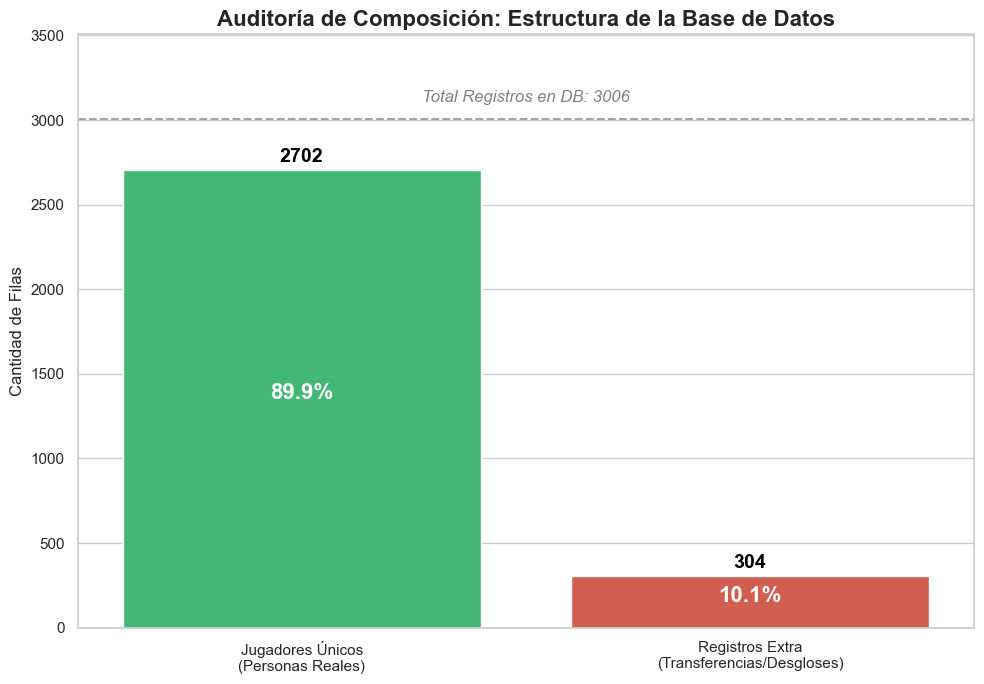

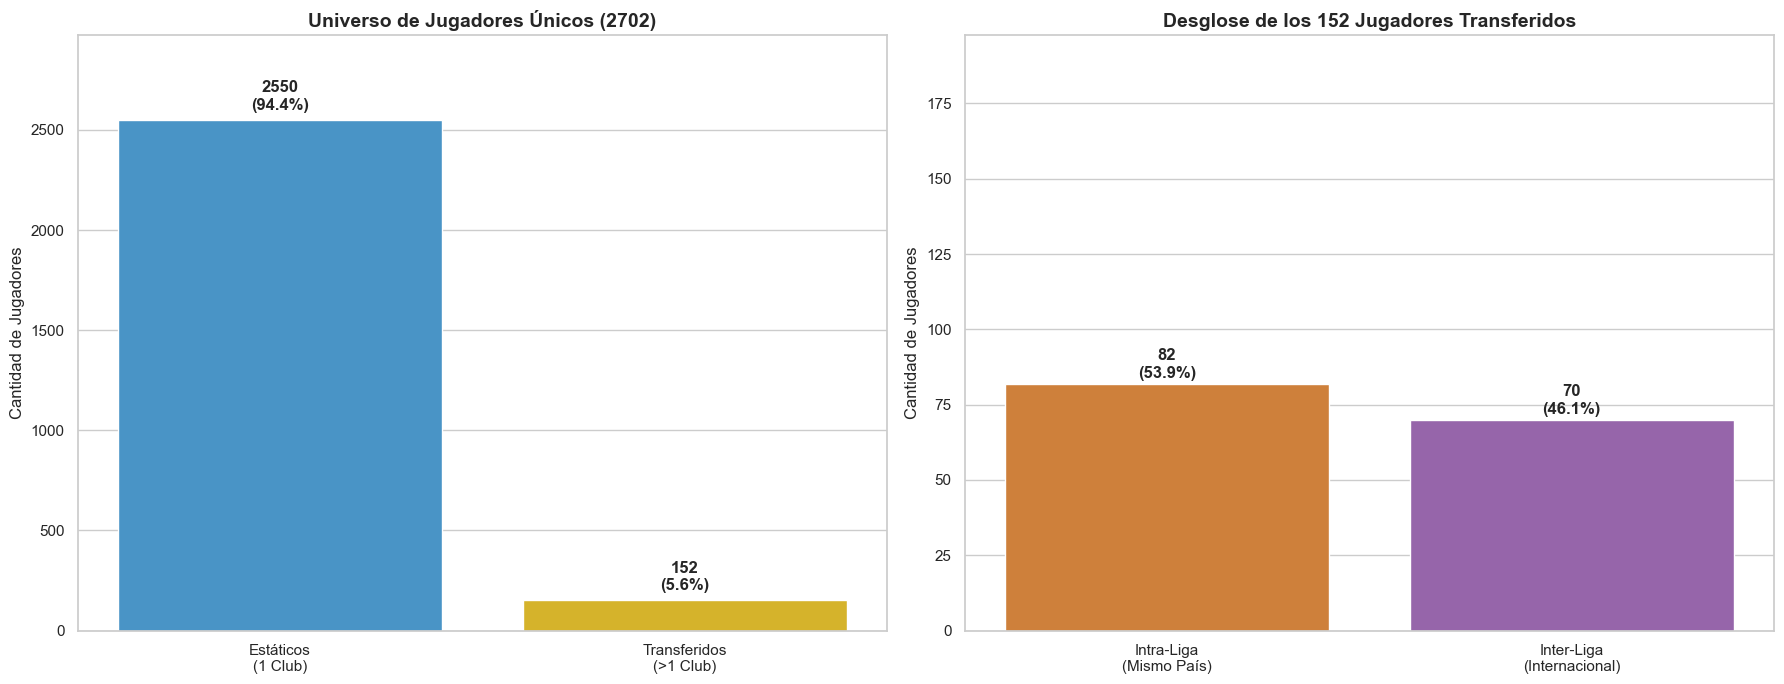

Validación G1: 2550 + 152 = 2702
Validación G2: 82 + 70 = 152
🔎 CONCLUSIÓN FINAL:
El dataset contiene 3006 filas.
Representan a 2702 atletas únicos.
De esos 2702, 152 estuvieron en más de 1 equipo en la temporada 24-25.
Para ser más precisos, 82 fueron transferencias intraliga y 70 fueron transferencia interligas.
⚠️ De dónde sale entonces el 304?. De esos 152. Como a cada jugador transferido se le añaden 2 filas más (una por cada equipo), entonces 152*2= 304.
Por lo tanto, 304 filas adicionales que corresponden a desgloses por equipo de jugadores transferidos.


In [7]:
# ==================================
#  GRÁFICO 1: COMPOSICION DE LA BASE
# ==================================

# 1. Cálculos de Composición
total_filas = len(df)
jugadores_unicos = df['player_name'].nunique()
# Las filas "Extra" son la diferencia. Son las filas parciales de jugadores que se movieron, ya sea intra o interliga

filas_redundantes = total_filas - jugadores_unicos 

# 2. Crear un pequeño DataFrame para graficar
data_plot = pd.DataFrame({
    'Tipo de Dato': ['Jugadores Únicos\n(Personas Reales)', 'Registros Extra\n(Transferencias/Desgloses)'],
    'Cantidad': [jugadores_unicos, filas_redundantes]
})

# 3. Visualización
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Crear gráfico de barras
ax = sns.barplot(data=data_plot, x='Tipo de Dato', y='Cantidad', hue='Tipo de Dato', palette=['#2ecc71', '#e74c3c'])

# Títulos y Estilo
plt.title('Auditoría de Composición: Estructura de la Base de Datos', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Filas', fontsize=12)
plt.xlabel('')
plt.ylim(0, total_filas + 500) # Dar espacio arriba

# Etiquetado
for i, v in enumerate(data_plot['Cantidad']):
    # Poner el número total arriba de la barra
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=14, color='black')
    
    # Poner el porcentaje dentro de la barra
    pct = (v / total_filas) * 100
    ax.text(i, v / 2, f"{pct:.1f}%", ha='center', fontweight='bold', fontsize=16, color='white')

# Línea de referencia del Total
plt.axhline(y=total_filas, color='gray', linestyle='--', alpha=0.7)
plt.text(0.5, total_filas + 100, f'Total Registros en DB: {total_filas}', 
         ha='center', color='gray', fontsize=12, style='italic')

plt.tight_layout()
plt.show()


# =============================================
# GRÁFICO 2: DESGLOSE DE JUGADORES TRANSFERIDOS
# =============================================


# A. Identificar jugadores transferidos vs estáticos
player_counts = df['player_name'].value_counts()
transfer_players_list = player_counts[player_counts > 1].index.tolist()

num_transferred = len(transfer_players_list)
total_unique_players = df['player_name'].nunique()
num_static = total_unique_players - num_transferred

# B. Clasificar el TIPO de transferencia (Intra vs Inter)
intra_league_players = 0
inter_league_players = 0

for player in transfer_players_list:
    # Miramos sus filas parciales para ver las ligas
    player_rows = df[(df['player_name'] == player) & (df['record_type'] == 'Parcial')]
    unique_leagues = player_rows['league_id'].nunique()
    
    if unique_leagues == 1:
        intra_league_players += 1
    else:
        inter_league_players += 1

# --- PREPARACIÓN DE DATOS PARA GRAFICAR ---

# Gráfico 1: Total Jugadores (2702)
df_graph1 = pd.DataFrame({
    'Tipo de Jugador': ['Estáticos\n(1 Club)', 'Transferidos\n(>1 Club)'],
    'Cantidad': [num_static, num_transferred],
    'Color': ['#3498db', '#f1c40f'] # Azul, Amarillo
})

# Gráfico 2: Desglose de Transferidos (152)
df_graph2 = pd.DataFrame({
    'Tipo de Transferencia': ['Intra-Liga\n(Mismo País)', 'Inter-Liga\n(Internacional)'],
    'Cantidad': [intra_league_players, inter_league_players],
    'Color': ['#e67e22', '#9b59b6'] # Naranja, Violeta
})

# --- VISUALIZACIÓN ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_theme(style="whitegrid")

# GRÁFICO 1: Estáticos vs Transferidos
sns.barplot(data=df_graph1, x='Tipo de Jugador', y='Cantidad', hue='Tipo de Jugador', palette=df_graph1['Color'].tolist(), ax=axes[0], legend=False)
axes[0].set_title(f'Universo de Jugadores Únicos ({total_unique_players})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad de Jugadores')
axes[0].set_xlabel('')
axes[0].set_ylim(0, total_unique_players * 1.1)

# Etiquetas G1
for i, v in enumerate(df_graph1['Cantidad']):
    pct = (v / total_unique_players) * 100
    axes[0].text(i, v + 50, f"{v}\n({pct:.1f}%)", ha='center', fontweight='bold', fontsize=12)

# GRÁFICO 2: Desglose de Transferencias
sns.barplot(data=df_graph2, x='Tipo de Transferencia', y='Cantidad',hue='Tipo de Transferencia', palette=df_graph2['Color'].tolist(), ax=axes[1],legend=False)
axes[1].set_title(f'Desglose de los {num_transferred} Jugadores Transferidos', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cantidad de Jugadores')
axes[1].set_xlabel('')
axes[1].set_ylim(0, num_transferred * 1.3)

# Etiquetas G2
for i, v in enumerate(df_graph2['Cantidad']):
    pct = (v / num_transferred) * 100
    axes[1].text(i, v + 2, f"{v}\n({pct:.1f}%)", ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Validación
print(f"Validación G1: {num_static} + {num_transferred} = {num_static + num_transferred}")
print(f"Validación G2: {intra_league_players} + {inter_league_players} = {intra_league_players + inter_league_players}")

print(f"🔎 CONCLUSIÓN FINAL:")
print(f"El dataset contiene {total_filas} filas.")
print(f"Representan a {jugadores_unicos} atletas únicos.")
print(f"De esos {jugadores_unicos}, {num_transferred} estuvieron en más de 1 equipo en la temporada 24-25.")
print(f"Para ser más precisos, {intra_league_players} fueron transferencias intraliga y {inter_league_players} fueron transferencia interligas.")
print(f"⚠️ De dónde sale entonces el 304?. De esos {num_transferred}. Como a cada jugador transferido se le añaden 2 filas más (una por cada equipo), entonces {num_transferred}*2= {filas_redundantes}.")
print(f"Por lo tanto, {filas_redundantes} filas adicionales que corresponden a desgloses por equipo de jugadores transferidos.")

📐 Dimensiones del Dataset: 3006 filas x 150 columnas 



C:\Users\Admin\AppData\Local\Temp\ipykernel_1572\1938169847.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')


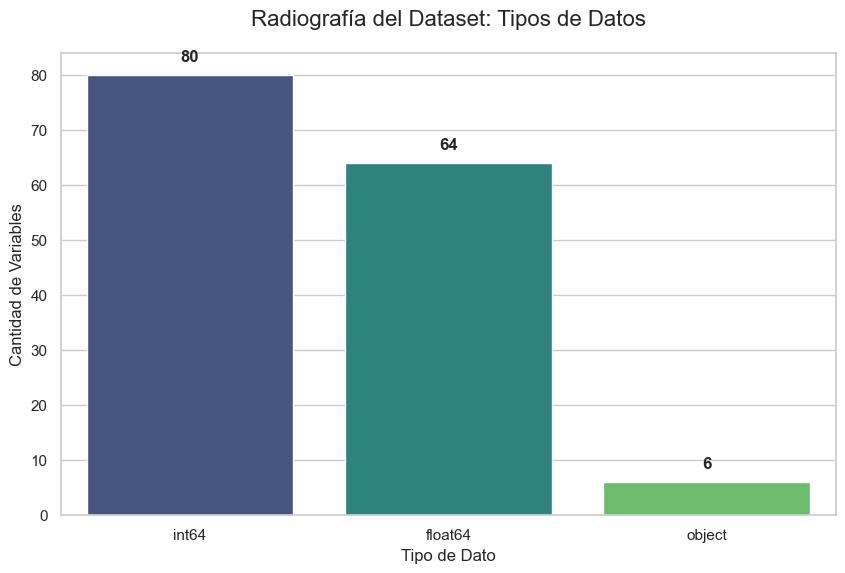

📊 Inventario Completo de Variables por Tipo:


,Tipo de Dato,Cantidad,Variables
0,int64,80,"rank, matches_played, starts, minutes_played, goals, assists, goals_assists, non_penalty_goals, pk_goals, pk_attempts, yellow_cards, red_cards, progressive_carries, progressive_passes, progressive_runs, shots_total, shots_on_target, free_kick_shots, passes_completed, passes_attempted, pass_total_distance, pass_progressive_distance, key_passes, passes_final_third, passes_penalty_area, crosses_penalty_area, passes_live, passes_dead, passes_through_balls, passes_switches, passes_crosses, passes_throw_ins, corner_kicks, corner_kicks_in, corner_kicks_out, corner_kicks_straight, offsides, blocks, sca, sca_pass_live, sca_pass_dead, sca_dribble, fouls_drawn, sca_defense, gca, tackles_total, tackles_won, tackles_def_3rd, tackles_mid_3rd, tackles_att_3rd, challenges_lost, blocks_passes, interceptions, tackles_interceptions, clearances, errors_leading_to_goal, touches, touches_def_pen_area, touches_att_pen_area, dribbles_completed, dribbles_tackled, carries, carries_penalty_area, miscontrols, dispossessed, passes_received, matches_completed, matches_subbed_in, unused_sub, on_goals_for, on_goals_against, plus_minus, second_yellow_card, fouls_committed, pk_won, pk_conceded, own_goals, ball_recoveries, aerials_won, team_order"
1,float64,64,"age, born, nineties, xg, npxg, xag, npxg_plus_xa, non_penalty_goals_assists, expected_goals_assists, shots_on_target_pct, shots_p90, shots_on_target_p90, goals_per_shot, goals_per_sot, avg_shot_distance, npxg_per_shot, goals_minus_xg, np_goals_minus_npxg, pass_completion_pct, xa, assists_minus_xa, sca_p90, gca_p90, challenge_tackles_pct, dribble_success_pct, dribbles_tackled_pct, minutes_per_match, minutes_pct, minutes_per_start, minutes_per_sub, points_per_match, plus_minus_p90, plus_minus_on_off, on_xg_for, on_xg_against, xg_plus_minus, xg_plus_minus_p90, aerials_won_pct, goals_against, goals_against_p90, shots_on_target_against, saves, save_pct, wins, draws, losses, clean_sheets, clean_sheet_pct, pk_allowed, pk_saved, pk_missed, psxg, psxg_per_sot, psxg_plus_minus, gk_passes_attempted_launch, gk_throws, launch_pct, avg_pass_length, gk_crosses_faced, crosses_stopped, crosses_stopped_pct, def_actions_outside_box, def_actions_outside_box_p90, avg_keeper_sweeper_dist"
2,object,6,"player_name, nation, main_position_group, squad, league_id, record_type"



ℹ️ Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 150 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    player_name                  3006 non-null   object 
 1    nation                       3006 non-null   object 
 2    main_position_group          3006 non-null   object 
 3    squad                        3006 non-null   object 
 4    league_id                    3006 non-null   object 
 5    age                          3006 non-null   float64
 6    record_type                  3006 non-null   object 
 7    rank                         3006 non-null   int64  
 8    born                         3006 non-null   float64
 9    matches_played               3006 non-null   int64  
 10   starts                       3006 non-null   int64  
 11   minutes_played               3006 non-null   int64  
 12   nineties             

In [ ]:
# Análisis estructural de la base
# 1. Verificación de Dimensiones
print(f"📐 Dimensiones del Dataset: {df.shape[0]} filas x {df.shape[1]} columnas \n")

#==========================================================================================================

# 2. Preparación datos para el gráfico de tipos de variables

# 2.1. Obtención de los tipos de datos
dtype_counts = df.dtypes.value_counts()

# 2.2. Configuración Visual
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# 2.3. Gráfico de Barras
barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')

# 2.4. Títulos y Etiquetas
plt.title('Radiografía del Dataset: Tipos de Datos', fontsize=16, pad=20)
plt.xlabel('Tipo de Dato', fontsize=12)
plt.ylabel('Cantidad de Variables', fontsize=12)

# 2.5. Añadir etiquetas de valor sobre las barras
for i, v in enumerate(dtype_counts.values):
    barplot.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.show()

#==========================================================================================================

# 3. Tabla completa de tipo de datos

# 3.1 Agrupación columnas por tipo de dato
dtype_summary = df.columns.to_series().groupby(df.dtypes).apply(list).reset_index()
dtype_summary.columns = ['Tipo de Dato', 'Lista de Variables']

# 3.2 Añadir conteo
dtype_summary['Cantidad'] = dtype_summary['Lista de Variables'].apply(len)

# 3.3 Formatear la lista completa (Sin truncar)

# Se unió toda la lista en un solo string separado por comas
dtype_summary['Variables'] = dtype_summary['Lista de Variables'].apply(lambda x: ', '.join(x))

# 3.4 Configuración para ver TODO el texto
pd.set_option('display.max_colwidth', None)

# 3.5 Mostrar tabla
print("📊 Inventario Completo de Variables por Tipo:")
display(dtype_summary[['Tipo de Dato', 'Cantidad', 'Variables']])


#==========================================================================================================

# 4. Información Técnica Completa (Memoria, Nulos, Dtypes)
print("\nℹ️ Información General del DataFrame:")
df.info(verbose=True, show_counts=True)

In [ ]:
# ==============================================================================
# ERRORES PROVENIENTES DEL ETL
# ==============================================================================
"""
    
print("\n" + "="*50)
print("1. VISIÓN GENERAL (HEALTH CHECK)")
print("="*50)

# A. Integridad de la Base (Nulos)
#    Aquí se crea específicamente un df que proporcione los valores nulos y otros tipos de datos más

def elite_audit(df):

    # Genera un reporte de salud básico del dataframe.
    
    # 1. Tipos de datos
    audit = pd.DataFrame(df.dtypes, columns=['Dtype'])
    
    # 2. Conteo de nulos y porcentaje
    audit['Nulos'] = df.isnull().sum()
    audit['% Nulos'] = (df.isnull().sum() / len(df)) * 100
    
    # 3. Valores únicos (Cardinalidad)
    audit['Unicos'] = df.nunique()
    
    # 4. Memoria (opcional, bueno para Big Data)
    audit['Memoria_KB'] = df.memory_usage(deep=True) // 1024
    
    
    return audit.sort_values(by='% Nulos', ascending=False)

# Ejecución de la auditoría

reporte = elite_audit(df)
display(reporte)

"""




1. VISIÓN GENERAL (HEALTH CHECK)


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
minutes_per_sub,float64,152,5.056554,62,23
aerials_won_pct,float64,152,5.056554,472,23
minutes_pct,float64,152,5.056554,874,23
minutes_per_start,float64,152,5.056554,52,23
save_pct,float64,152,5.056554,122,23
pass_completion_pct,float64,152,5.056554,416,23
dribbles_tackled_pct,float64,152,5.056554,350,23
shots_on_target_pct,float64,152,5.056554,278,23
dribble_success_pct,float64,152,5.056554,343,23
clean_sheet_pct,float64,152,5.056554,88,23


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

#   nulos_float = reporte[(reporte['% Nulos'] > 0) & (reporte['Dtype'] == 'float64')]
#   nulos_float



In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

# Quiero ver ahora si es que los valores nulos de las columnas que presentan valores NaN en columnas float, se concentran en algún "squad" específico, por ejemplo "COMBINADAS"

#   nulos_float_squads = df[df[nulos_float.index].isnull().any(axis=1)]['squad'].value_counts()
#   display(nulos_float_squads)

#   print('Las variables que quedaron con valores NaN son porcentajes "_pct", ' \
#   'o bien otras variables que no serían correcto sumarlas en las COMBINADAS. ' \
#   '\nSe tratará en la featuring engeneering esto. ')

# Ejemplo para ver que en las 

#   df[df[nulos_float.index].isnull().any(axis=1)].head(10)

In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

#====================================================================================

"""reporte_age_nulos = reporte.loc[reporte.index == 'age']
   display(reporte_age_nulos)

# Obtención del nombre de los jugadores que no tienen edad, año de nacimiento ni nacion registrada en el dataframe original df.

   jugadores_sin_datos = df[df['age'].isnull()][['player_name', 'age','born','nation']]
   display(jugadores_sin_datos)

# Como ya se corrigió el problema en el ETL entonces el problema fue solucionado

   if jugadores_sin_datos.shape[0]:
       print(f"Se encontraron {len(jugadores_sin_datos)} jugadores sin datos:")
       for g in jugadores_sin_datos:
           print("  -", ", ".join(g))
   else:
       print("No se encontraron jugadores sin datos de 'age', 'born' o 'nation'." \
       "\nTrabajo Completado!") """


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

# Busca columnas que tienen exactamente los mismos valores (incluyendo NaN en mismas posiciones)
#   columnas_duplicadas = []
#   _checked = set()
#   cols = df.columns.tolist()

""" for i, c in enumerate(cols):
    if c in _checked:
        continue
    grupo = [c]
    for c2 in cols[i+1:]:
        # Series.equals considera NaN en mismas posiciones como iguales
        if df[c].equals(df[c2]):
            grupo.append(c2)
            _checked.add(c2)
    if len(grupo) > 1:
        columnas_duplicadas.append(grupo)

# Resultado legible
if columnas_duplicadas:
    print(f"Se encontraron {len(columnas_duplicadas)} grupos de columnas duplicadas (por contenido):")
    for g in columnas_duplicadas:
        print("  -", ", ".join(g))
else:
    print("No se encontraron columnas duplicadas por contenido." \
    "\nTrabajo completado!") """

📊 Generando Auditoría de Nulos en 3 partes para 150 variables...
Amarillo = nulo, Violeta = dato


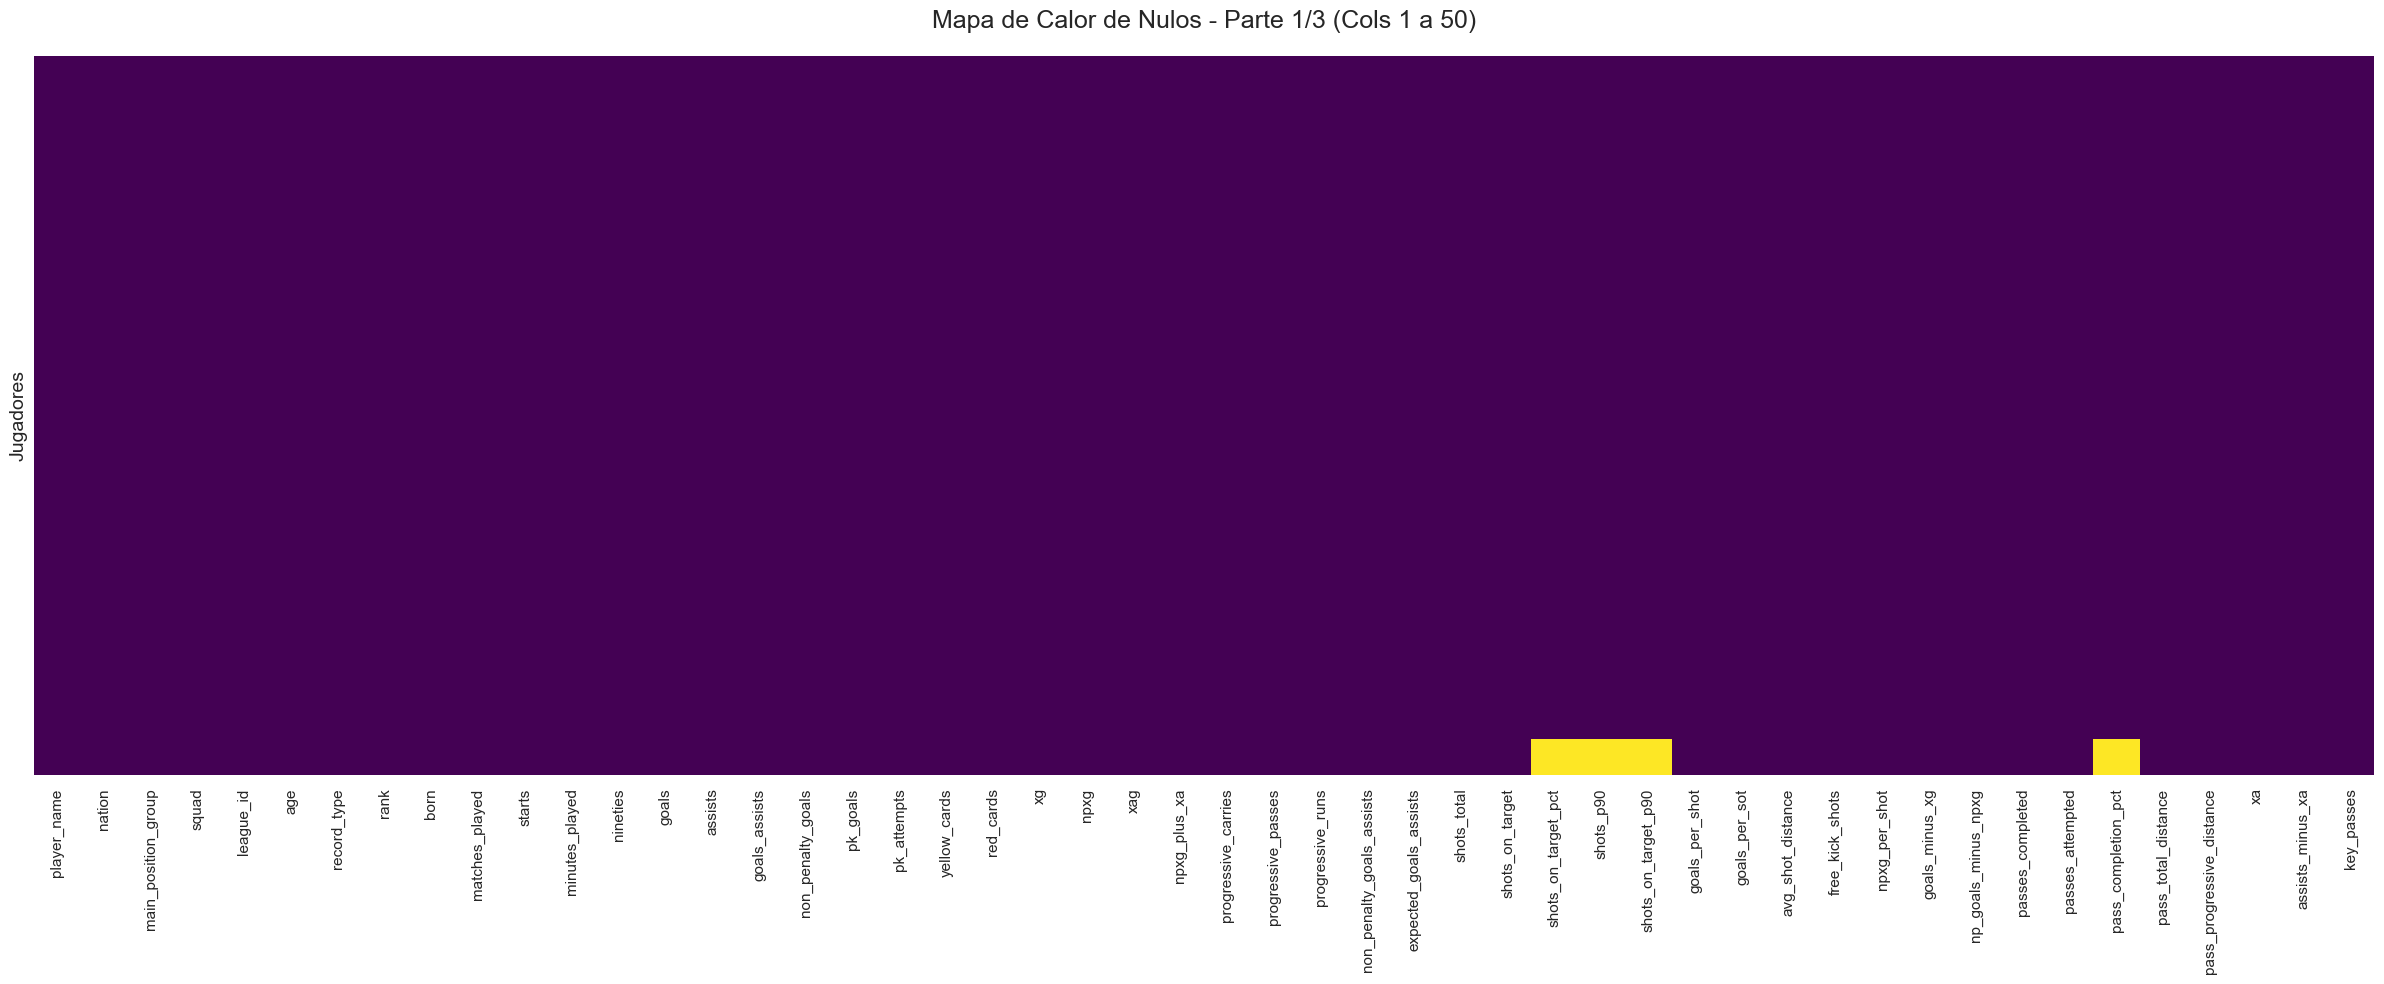

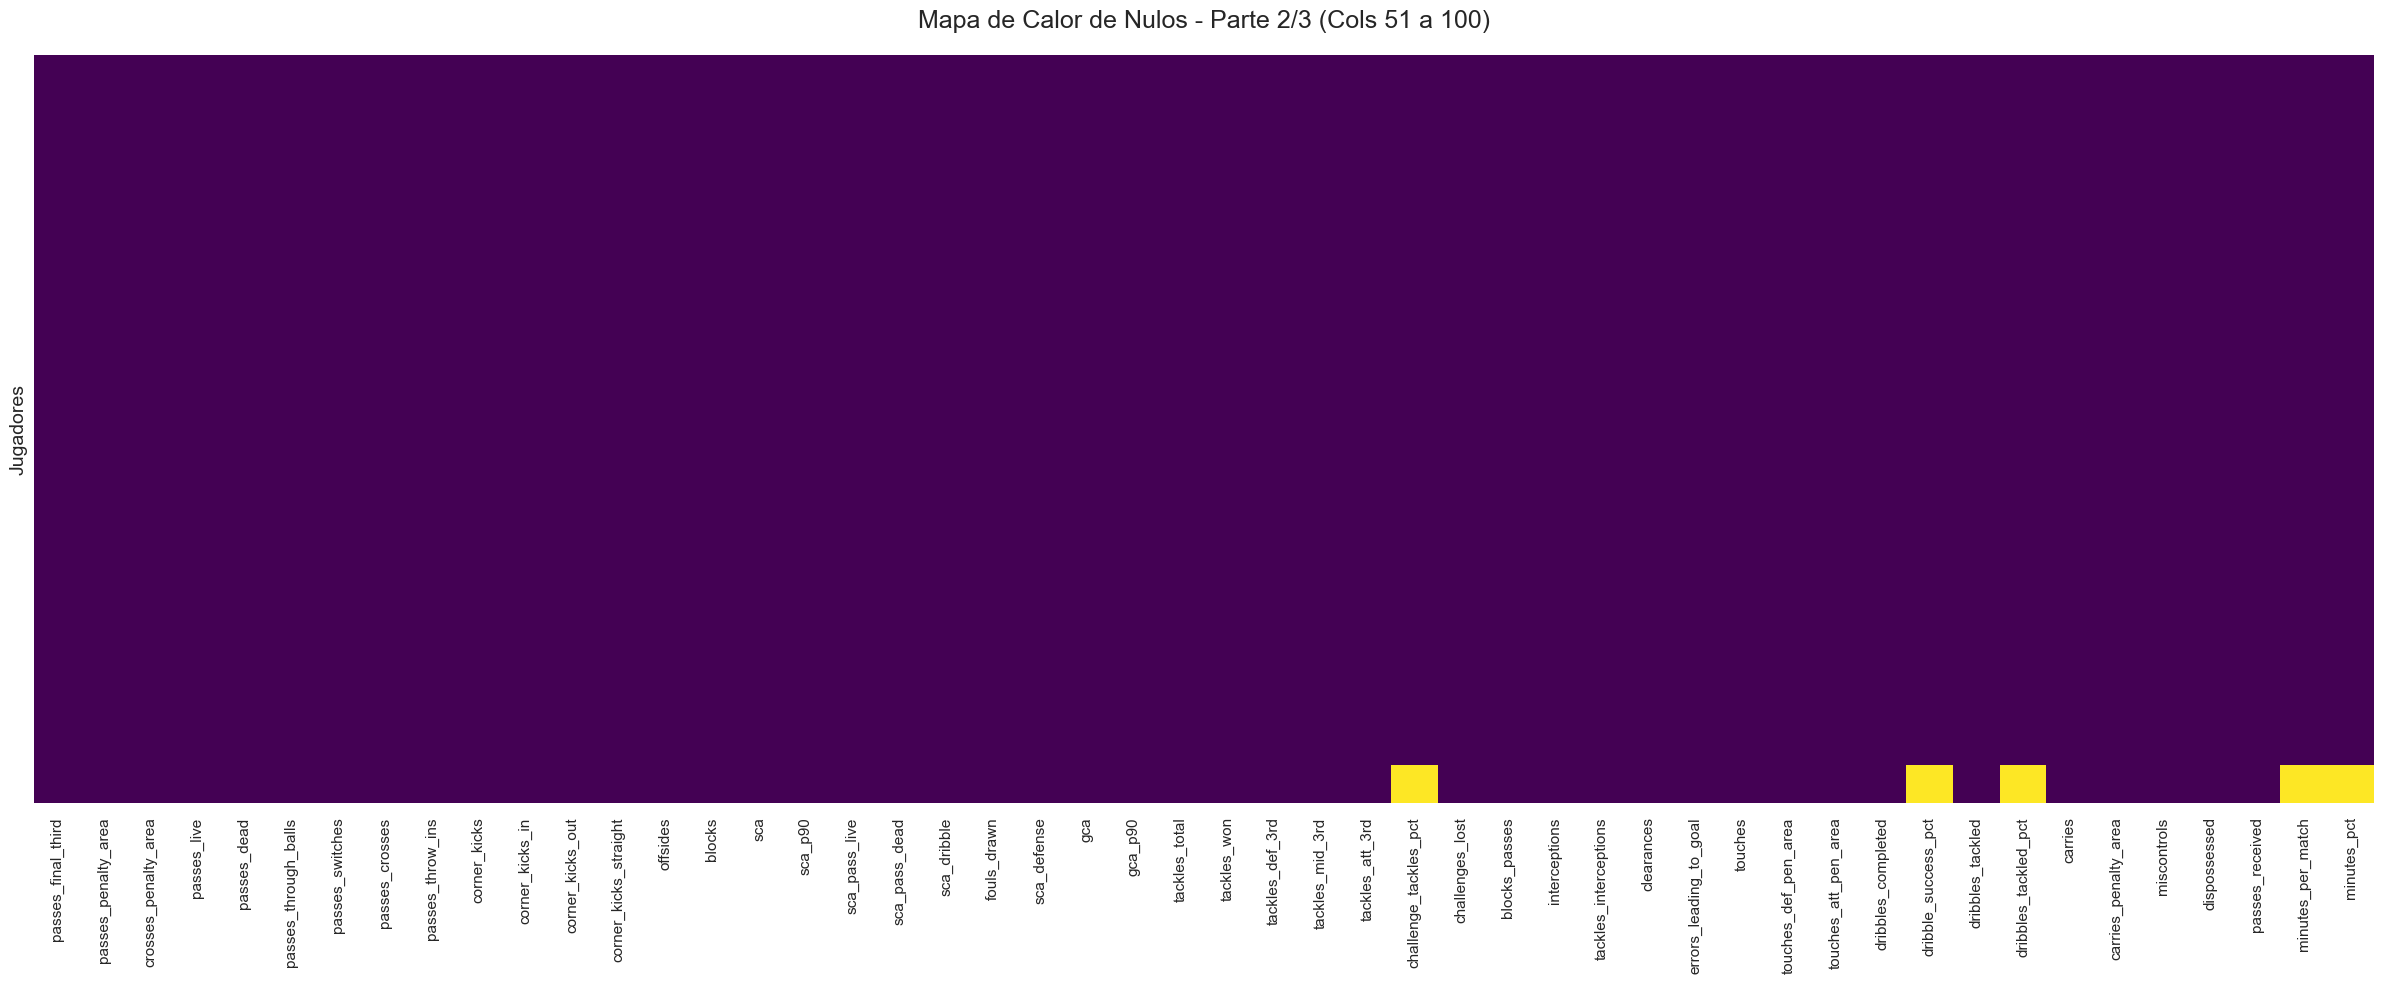

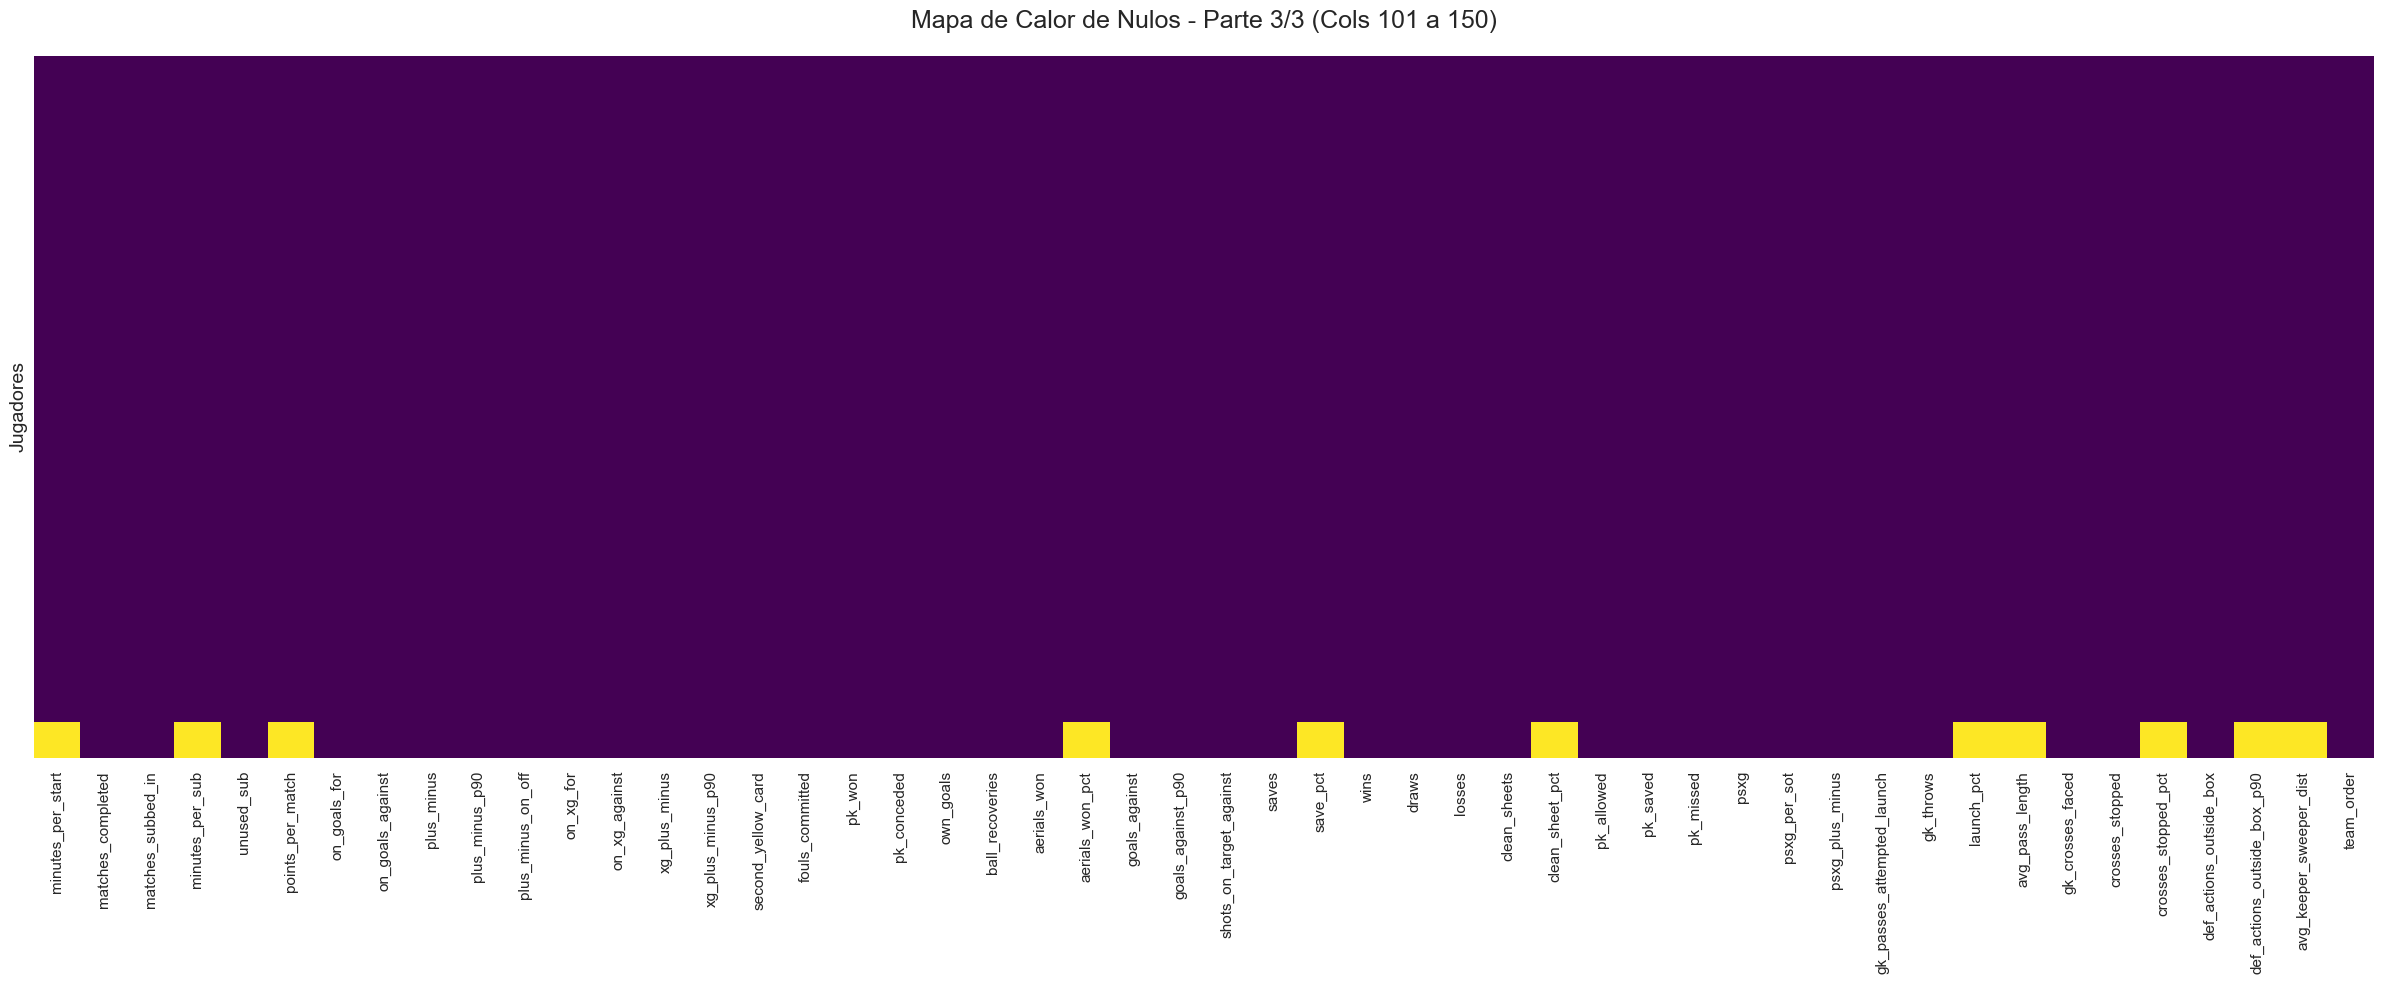

In [ ]:
# MAPAS DE CALOR DE NULOS

# 1. Configuración del gráfico

sns.set_theme(style="whitegrid")

# 2. Lógica de División (Chunking)
chunk_size = 50 # Cantidad de columnas por gráfico
total_cols = len(df.columns)
num_chunks = math.ceil(total_cols / chunk_size)

print(f"📊 Generando Auditoría de Nulos en {num_chunks} partes para {total_cols} variables...\nAmarillo = nulo, Violeta = dato")

# 3. Generación de Gráficos
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, total_cols)
    
    # Seleccionar subconjunto
    df_subset = df.iloc[:, start:end]
    
    # Crear Figura
    plt.figure(figsize=(24, 10)) # Ancho extra para leer los nombres
    
    # Mapa de Calor (Amarillo = Nulo, Violeta = Dato)
    sns.heatmap(df_subset.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    
    # Títulos y Etiquetas
    plt.title(f'Mapa de Calor de Nulos - Parte {i+1}/{num_chunks} (Cols {start+1} a {end})', fontsize=18, pad=20)
    plt.xticks(rotation=90, fontsize=11) # Rotar nombres para que se lean
    plt.ylabel('Jugadores', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Filas COMBINED: 152
Filas SINGLE: 2854



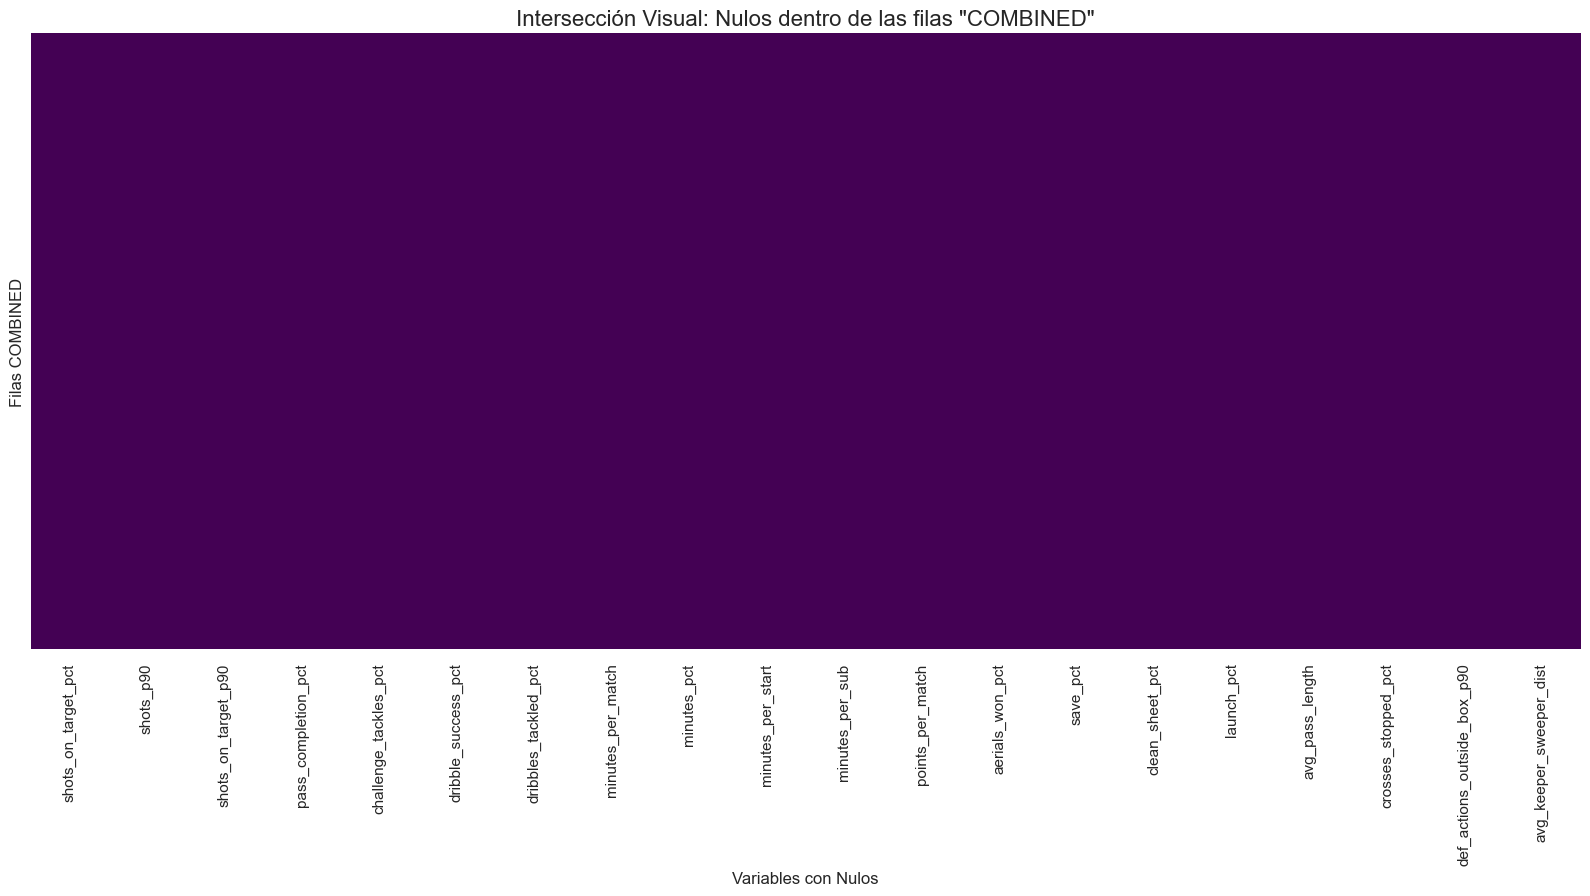



>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<
                             % Nulos en COMBINED  % Nulos en SINGLE
shots_on_target_pct                        100.0                0.0
crosses_stopped_pct                        100.0                0.0
avg_pass_length                            100.0                0.0
launch_pct                                 100.0                0.0
clean_sheet_pct                            100.0                0.0
save_pct                                   100.0                0.0
aerials_won_pct                            100.0                0.0
points_per_match                           100.0                0.0
minutes_per_sub                            100.0                0.0
minutes_per_start                          100.0                0.0
minutes_pct                                100.0                0.0
minutes_per_match                          100.0                0.0
dribbles_tackled_pct                   

In [ ]:
# Aquí se comprueba que los valores nulos se corresponden con los valores "COMBINED"

# 1. Separar el universo en dos: 'Combined' (Totales) vs 'Single' (Equipos individuales)
df_combined = df[df['squad'] == 'COMBINED']
df_single = df[df['squad'] != 'COMBINED']

print(f"Filas COMBINED: {len(df_combined)}")
print(f"Filas SINGLE: {len(df_single)}")
print('\n',"=" * 80)

# 2. Identificar columnas con Nulos
# Solo nos interesan las columnas que tienen algún dato faltante
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if not cols_with_nulls:
    print("¡No hay nulos en el dataset!")
else:
    # --- VISUALIZACIÓN 1: MAPA DE CALOR SOLO DE 'COMBINED' ---
    plt.figure(figsize=(20, 8))
    # Filtramos el DF para ver solo filas COMBINED y solo columnas problemáticas
    sns.heatmap(df_combined[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Intersección Visual: Nulos dentro de las filas "COMBINED"', fontsize=16)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Filas COMBINED')
    plt.xticks(rotation=90)
    plt.show()

    # --- ANÁLISIS 2: COMPARATIVA NUMÉRICA (LA PRUEBA DE FUEGO) ---
    # Calculamos el % de nulos en cada grupo
    null_pct_combined = df_combined[cols_with_nulls].isnull().mean() * 100
    null_pct_single = df_single[cols_with_nulls].isnull().mean() * 100

    # Creamos un DataFrame para comparar
    comparison = pd.DataFrame({
        '% Nulos en COMBINED': null_pct_combined,
        '% Nulos en SINGLE': null_pct_single
    })
    
# 3. Filtramos para ver donde la diferencia es drástica (Hipótesis del ETL)

# Mostramos columnas donde Combined es 100% nulo pero Single tiene datos
print('\n',"=" * 80)
print("\n>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<")
pd.set_option('display.max_rows', None)
print(comparison[comparison['% Nulos en COMBINED'] > 90].sort_values('% Nulos en SINGLE'))

nulos = reporte[(reporte['% Nulos'] > 0)]

print('\n',"=" * 80)

print("\nEsta es la cantidad de columnas con valores nulos:", len(nulos))

In [ ]:
# Aquí se vió que era lo que contenía la columna 'unkdown_p90'. Su correción se aplicó al ETL.

#df_residual = df['unknown_p90']
#df_residual.unique()

"""
Al ver los valores (entre -2.72 y +1.17) y compararlos con las métricas de arqueros en FBref, 
esta columna es casi con seguridad PSxG+/- /90 (Post-Shot Expected Goals minus Goals Allowed per 90 minutes). 
Es decir, "cuántos goles extra salvó el arquero por partido.
Dado que ya tenemos la columna PSxG+/- (total), tener el "per 90" es redundante porque podemos calcularlo 
nosotros mismos (PSxG+/- dividido 90s). Por lo tanto, se eliminará esta columna. 
Para eliminarla se hará quitará la columna directamente en el ETL.
"""

⚠️ Se encontraron 20 variables con datos faltantes.


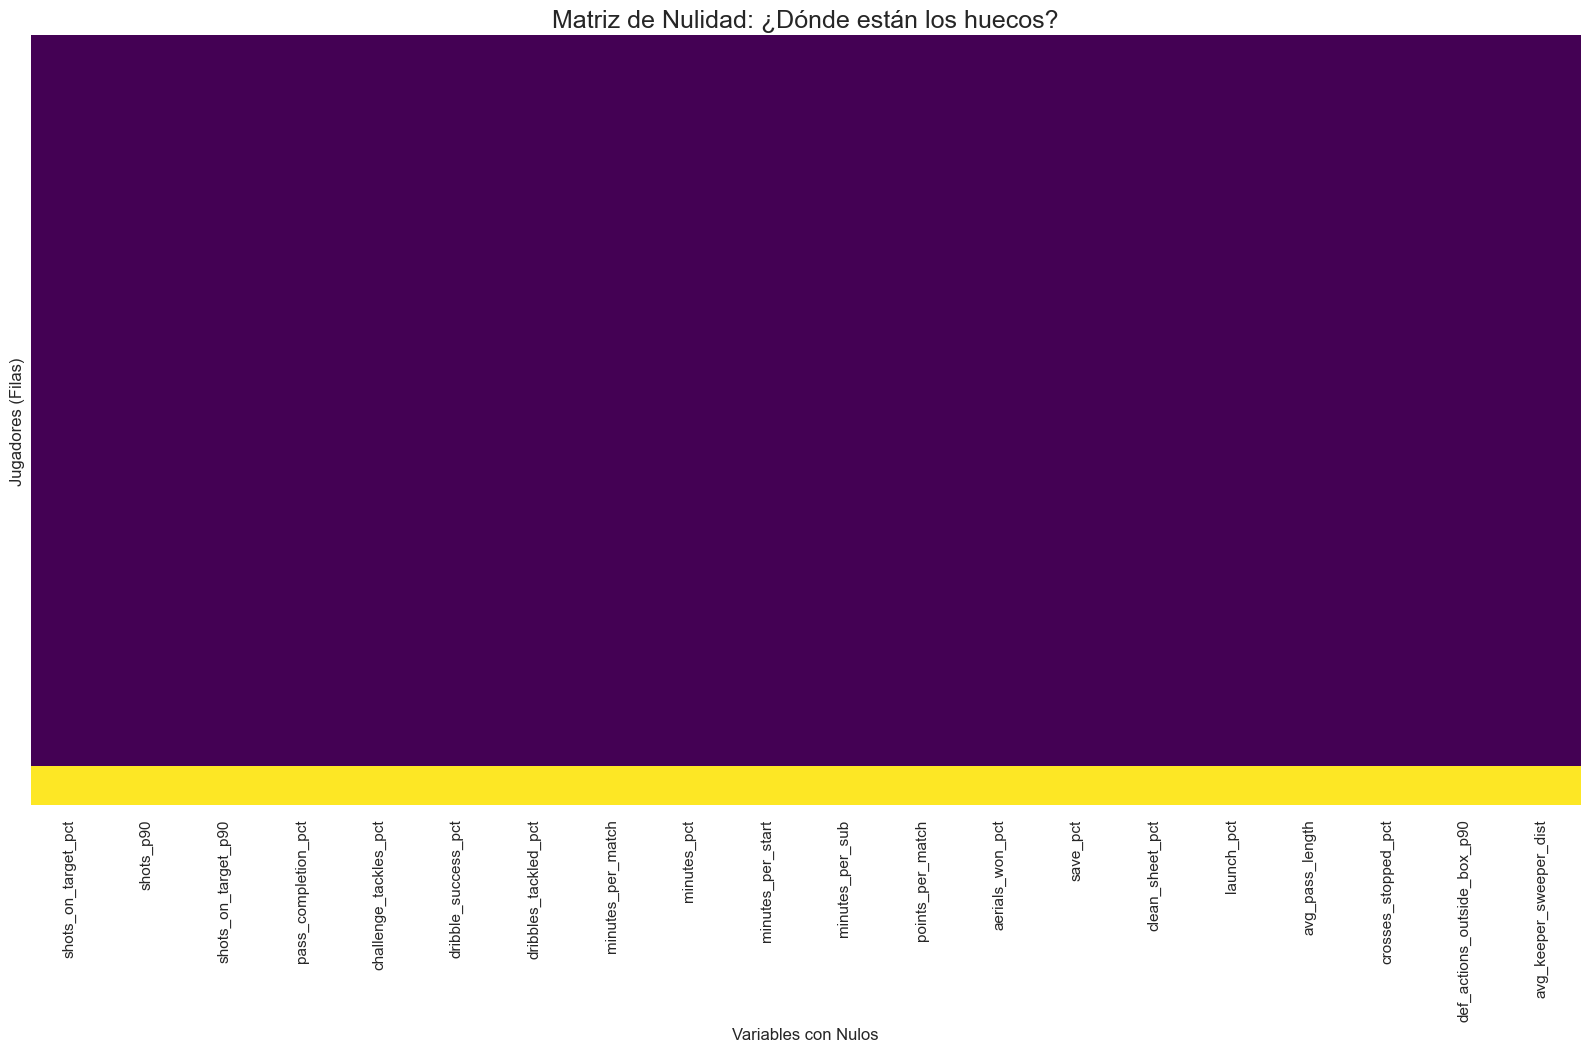

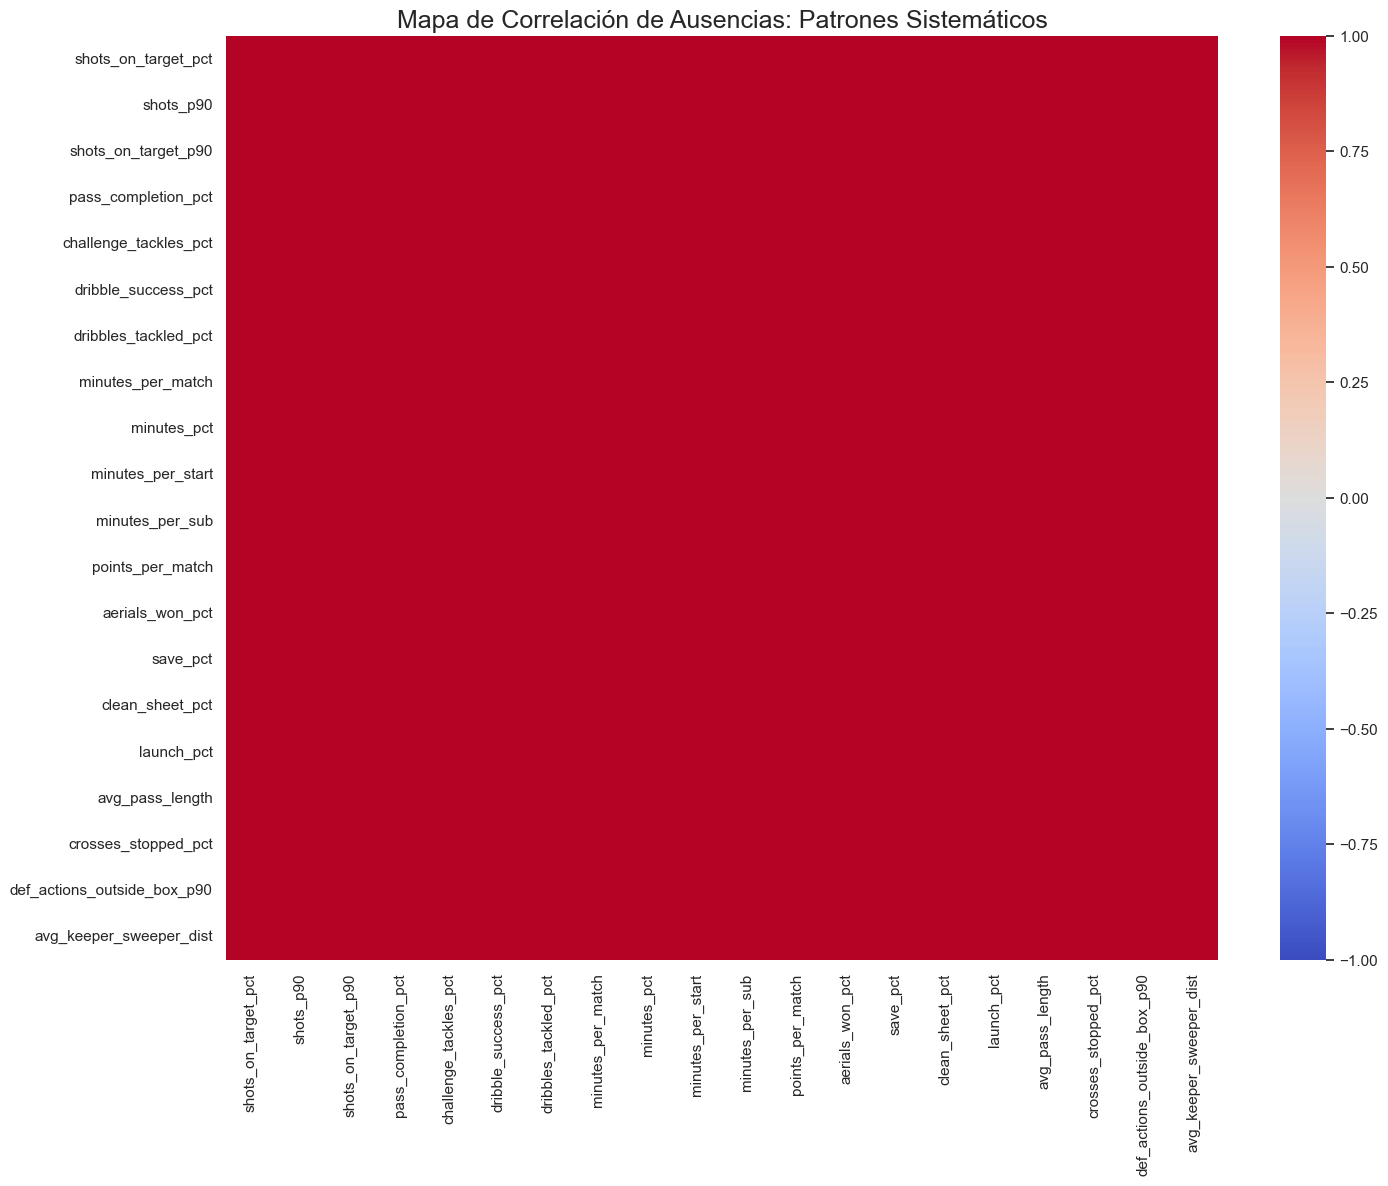

💡 INTERPRETACIÓN:
1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).
2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).


In [ ]:
# Matriz de Nulidad (Heatmap de ausencias)

# 1. Filtrar solo columnas que tienen algún nulo
# (Si graficamos las 150 columnas, no se verá nada. Nos enfocamos en el problema)
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if len(cols_with_nulls) == 0:
    print("✅ ¡Increíble! No hay un solo valor nulo en todo el dataset.")
else:
    print(f"⚠️ Se encontraron {len(cols_with_nulls)} variables con datos faltantes.")
    
    # --- GRÁFICO A: MATRIZ DE NULIDAD (Missingness Matrix) ---
    # Esto nos muestra DÓNDE están los nulos.
    # Eje X: Variables. Eje Y: Jugadores. Color: Dato faltante.
    plt.figure(figsize=(20, 10))
    sns.heatmap(df[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Matriz de Nulidad: ¿Dónde están los huecos?', fontsize=18)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Jugadores (Filas)')
    plt.xticks(rotation=90)
    plt.show()

    # --- GRÁFICO B: CORRELACIÓN DE NULIDAD (Systematic Pattern) ---
    # Esto responde: "Si falta A, ¿también falta B?"
    # 1 = Correlación perfecta (si falta uno, falta el otro).
    plt.figure(figsize=(16, 12))
    nullity_corr = df[cols_with_nulls].isnull().corr()
    
    sns.heatmap(nullity_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Mapa de Correlación de Ausencias: Patrones Sistemáticos', fontsize=18)
    plt.show()

    # Insight Automático:
    print("💡 INTERPRETACIÓN:")
    print("1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).")
    print("2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).")

In [ ]:
# ANALISIS DE DUPLICADOS

print(f"📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD")
print("-" * 40)

# 1. Análisis de Duplicados Totales (Filas idénticas)
total_dups = df.duplicated().sum()
print(f"1. Filas Totalmente Duplicadas: {total_dups}")
if total_dups == 0:
    print("   ✅ APROBADO: No hay filas repetidas.")
else:
    print(f"   ❌ ALERTA: Se encontraron {total_dups} duplicados exactos.")

# 2. Análisis de Llave Primaria (Constraint Check)

# En este dataset, un jugador no puede aparecer dos veces en el mismo equipo
pk_cols = ['player_name', 'squad']
pk_dups = df.duplicated(subset=pk_cols).sum()

print(f"\n2. Duplicados de Llave Primaria {pk_cols}: {pk_dups}")
if pk_dups == 0:
    print("   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.")
else:
    print(f"   ❌ FALLO: Hay {pk_dups} violaciones de integridad referencial.")
    # Mostrar culpables
    print(df[df.duplicated(subset=pk_cols, keep=False)].sort_values('player_name'))

📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD
----------------------------------------
1. Filas Totalmente Duplicadas: 0
   ✅ APROBADO: No hay filas repetidas.

2. Duplicados de Llave Primaria ['player_name', 'squad']: 0
   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.


#### 2. Estadística Descriptiva de las Variables

In [4]:
# ==============================================================================
# FUNCIÓN GENERADORA DE ANÁLISIS DESCRIPTIVO AMPLIO (RADIOGRAFÍA DE DATOS)
# ==============================================================================

def generar_radiografia_datos(df_target, nombre_poblacion="Población General"):
    """
    Genera un informe descriptivo completo con semáforos de calidad de datos.
    Calcula: Estadísticos básicos + Forma (Skew/Kurt) + Consistencia (Pearson) + Outliers (IQR).
    
    Args:
        df_target (pd.DataFrame): El dataframe a analizar (ej. df_global, df_anliga).
        nombre_poblacion (str): Etiqueta para el título del reporte.
    """
    
    # -------------------------------
    # 1. CONFIGURACIÓN VISUAL
    # -------------------------------
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    print(f"📊 ANÁLISIS DESCRIPTIVO: {nombre_poblacion.upper()} (N={len(df_target)} Registros)")
    print("="*80)

    # -------------------------------
    # 2. DEFINICIÓN DE SEMÁFOROS (FUNCIONES INTERNAS)
    # -------------------------------
    def resaltar_ceros(val):
        color = 'red' if val == 0 else ''
        return f'color: {color}; font-weight: bold' if val == 0 else ''

    def semaforo_skewness(val):
        if pd.isna(val): return ''
        if -0.5 <= val <= 0.5: return 'color: green; font-weight: bold'
        elif -1.0 <= val <= 1.0: return 'color: goldenrod; font-weight: bold'
        else: return 'color: red; font-weight: bold'

    def semaforo_kurtosis(val):
        if pd.isna(val): return ''
        if -1.0 <= val <= 1.0: return 'color: green; font-weight: bold'
        elif -2.0 <= val <= 2.0: return 'color: goldenrod; font-weight: bold'
        else: return 'color: red; font-weight: bold'

    def semaforo_pearson(val):
        if pd.isna(val): return ''
        if -0.5 <= val <= 0.5: return 'color: green; font-weight: bold'
        elif -1.0 <= val <= 1.0: return 'color: goldenrod; font-weight: bold'
        else: return 'color: red; font-weight: bold'

    def semaforo_outliers(val):
        if pd.isna(val): return ''
        if val < 5.0: return 'color: green; font-weight: bold'
        elif val <= 10.0: return 'color: goldenrod; font-weight: bold'
        else: return 'color: red; font-weight: bold'

    # -------------------------------
    # 3. CÁLCULOS NUMÉRICOS
    # -------------------------------
    print("\n>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<")
    
    # Selección de columnas numéricas solamente
    df_num = df_target.select_dtypes(include=['number'])
    
    if not df_num.empty:
        numeric_stats = df_num.describe().T
        
        # Métricas Avanzadas
        numeric_stats['median'] = df_num.median()
        numeric_stats['skewness'] = df_num.skew()
        numeric_stats['kurtosis'] = df_num.kurt()
        numeric_stats['asim_pearson'] = (3 * (numeric_stats['mean'] - numeric_stats['median'])) / numeric_stats['std']
        
        # Cálculo de Outliers (IQR)
        Q1 = df_num.quantile(0.25)
        Q3 = df_num.quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        
        outliers_count = ((df_num < lim_inf) | (df_num > lim_sup)).sum()
        numeric_stats['outliers_pct'] = (outliers_count / len(df_target)) * 100
        
        # Ordenamiento Táctico
        cols_order = ['count', 'mean', 'median', 'std', 'min', 'max', '25%', '75%', 
                      'skewness', 'kurtosis', 'asim_pearson', 'outliers_pct']
        numeric_stats = numeric_stats[cols_order]

        # -------------------------------
        # 4. VISUALIZACIÓN (LEYENDAS Y ESTILOS)
        # -------------------------------
        print("\nLEYENDA DE SEMÁFOROS:")
        print("1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada")
        print("2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos")
        print("3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa")
        print("4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)")
        print("-" * 80)
        
        styled_numeric = numeric_stats.style.format("{:.2f}")\
            .map(resaltar_ceros)\
            .map(semaforo_skewness, subset=['skewness'])\
            .map(semaforo_kurtosis, subset=['kurtosis'])\
            .map(semaforo_pearson, subset=['asim_pearson'])\
            .map(semaforo_outliers, subset=['outliers_pct'])
            
        display(styled_numeric)
    else:
        print("⚠️ No hay variables numéricas en este DataFrame.")

    # -------------------------------
    # 5. VARIABLES CATEGÓRICAS
    # -------------------------------
    print("\n>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<")
    df_cat = df_target.select_dtypes(include=['object'])
    
    if not df_cat.empty:
        categorical_stats = df_cat.describe().T
        display(categorical_stats)
        if 'squad' in df_target.columns or 'league_id' in df_target.columns:
             print("*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.")
    else:
        print("⚠️ No hay variables categóricas en este DataFrame.")

In [ ]:
# ==============================================
# ESTADÍSTICAS DESCRIPTIVAS GLOBALES
# ==============================================

generar_radiografia_datos(df_global, "Población de Registro Único (df_global)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN DE REGISTRO ÚNICO (DF_GLOBAL) (N=2702 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,2702.00,25.03,25.00,4.56,15.00,41.00,22.00,28.00,0.30,-0.43,0.02,0.44
rank,2702.00,1432.28,1437.50,819.56,1.00,2853.00,727.25,2139.75,-0.01,-1.19,-0.02,0.00
born,2702.00,1998.64,1999.00,4.56,1982.00,2009.00,1995.00,2002.00,-0.32,-0.40,-0.24,0.07
matches_played,2702.00,20.08,22.00,11.39,1.00,54.00,10.00,30.00,-0.27,-1.21,-0.50,0.00
starts,2702.00,14.26,12.50,11.37,0.00,38.00,3.00,24.00,0.34,-1.18,0.46,0.00
minutes_played,2702.00,1279.68,1153.00,966.95,1.00,3420.00,373.00,2083.75,0.34,-1.09,0.39,0.00
nineties,2702.00,14.22,12.80,10.74,0.00,38.00,4.10,23.10,0.34,-1.09,0.40,0.00
goals,2702.00,1.78,0.00,3.25,0.00,31.00,0.00,2.00,3.37,15.55,1.64,9.40
assists,2702.00,1.27,0.00,1.99,0.00,18.00,0.00,2.00,2.34,7.19,1.92,5.18
goals_assists,2702.00,3.05,1.00,4.65,0.00,47.00,0.00,4.00,2.69,10.16,1.32,7.44



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,2702,2702,Aaron Ciammaglichella,1
nation,2702,113,ESP,402
main_position_group,2702,4,DF,969
squad,2702,97,COMBINED,152
league_id,2702,6,La Liga,553
record_type,2702,2,Parcial,2550


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


📊 Generando Mosaico para Población Única: 2702 jugadores
   - Variables a graficar: 144
   - Se quitaron las siguientes columnas que no cumplieron con el criterio: Ninguna fue eliminada
   - Las únicas que se quitaron fueron las columnas: player_name, nation, main_position_group, squad, league_id, record_type


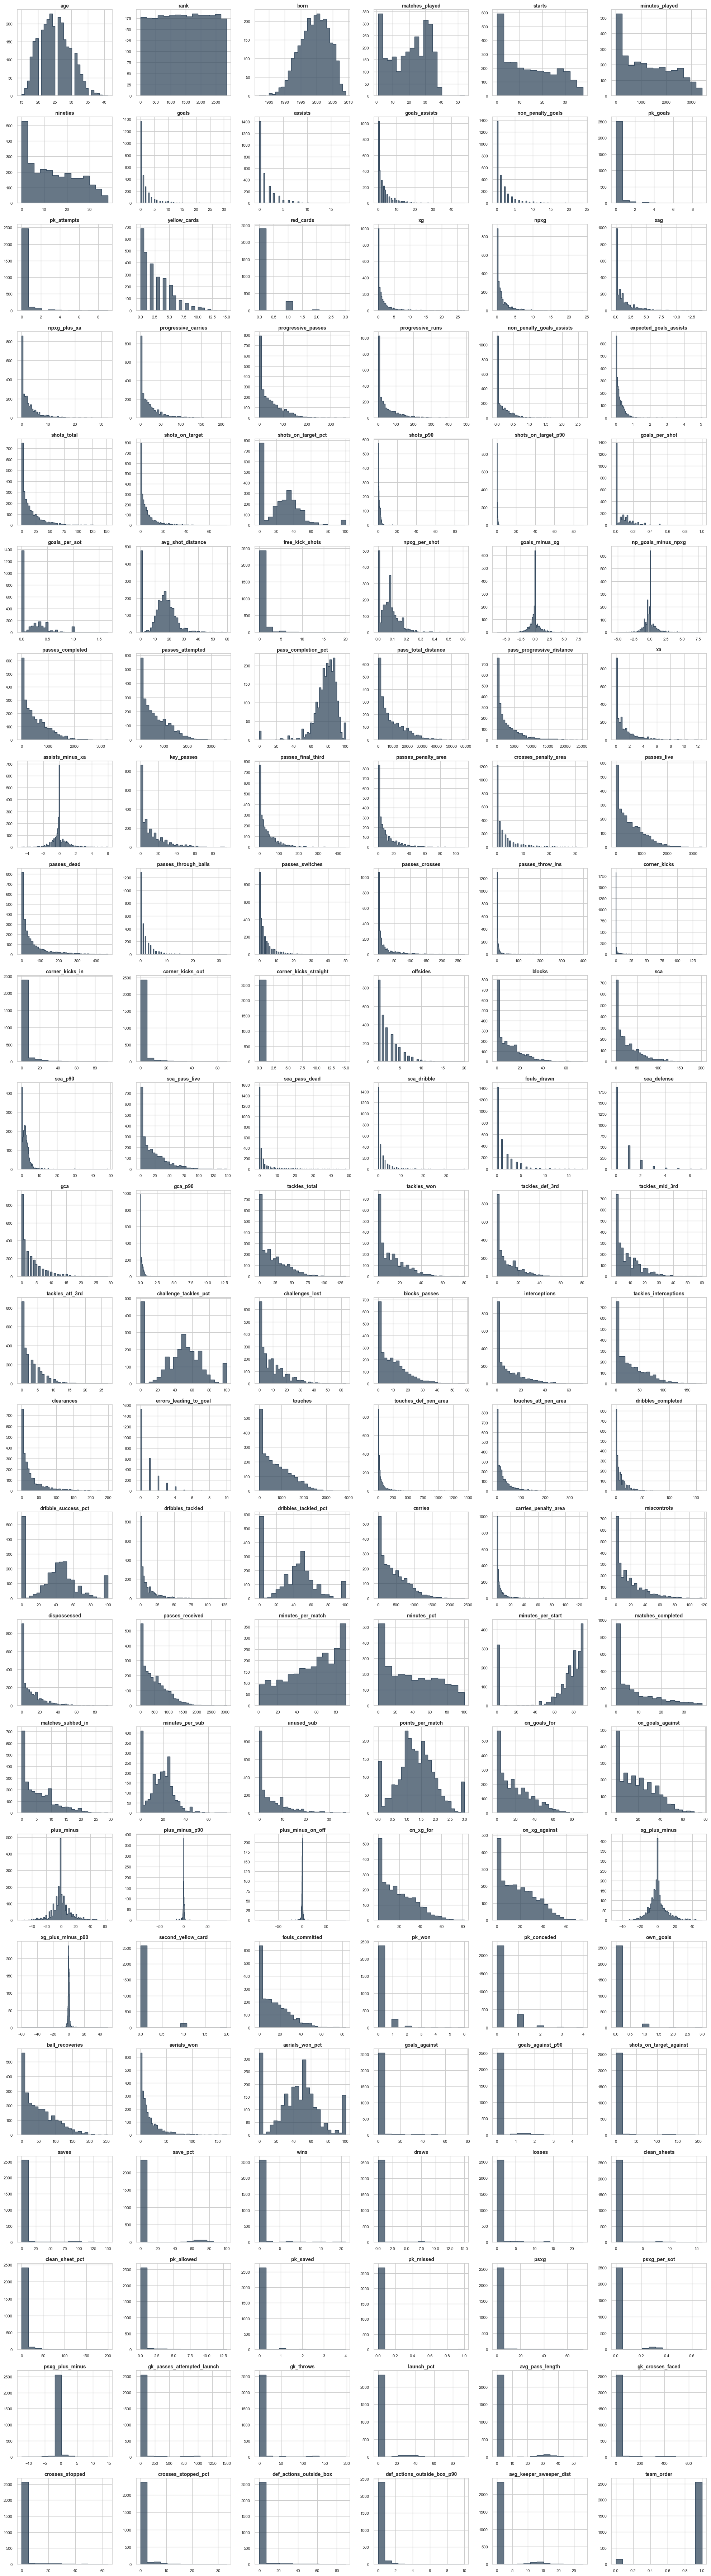

In [ ]:
# ==============================================
# GRÁFICO DE DISTRIBUCIÓN DE TODAS LAS VARIABLES
# ==============================================

# ----------------------------------------------------
# 1. PREPARACIÓN DE POBLACIÓN OBJETIVO. DATOS GLOBALES
# ----------------------------------------------------

# Se utiliza el df_glbal ya creado anteriormente que permite utilizar registros únicos por jugador

print(f"📊 Generando Mosaico para Población Única: {len(df_global)} jugadores")

# -------------------------------------
# 2. SELECCIÓN INTELIGENTE DE VARIABLES
# -------------------------------------

# 2.1. Solo Variables Numéricas
# ------------------------------

numeric_cols = df_global.select_dtypes(include=['float64', 'int64']).columns

# 2.2. Filtro de "Sombra de Datos" (Eliminar las muy vacías >50% nulos)
# ---------------------------------------------------------------------

# Esto es vital para que el gráfico no se llene de cuadros vacíos
threshold = 0.5
null_pct = df_global[numeric_cols].isnull().mean()
valid_cols = null_pct[null_pct < threshold].index.tolist()

total_cols = len(valid_cols)
cols_per_row = 6
rows = math.ceil(total_cols / cols_per_row)

# 2.3. Columnas DESCARTADAS (Más del 50% de nulos)
# ------------------------------------------------

dropped_cols = null_pct[null_pct >= threshold].index.tolist()

print(f"   - Variables a graficar: {total_cols}")
dropped_msg = ", ".join(dropped_cols) if dropped_cols else "Ninguna fue eliminada"
print(f"   - Se quitaron las siguientes columnas que no cumplieron con el criterio: {dropped_msg}")

nonnumeric_cols = df_global.select_dtypes(include=['object']).columns
cols_texto = ", ".join(nonnumeric_cols.tolist())
print(f"   - Las únicas que se quitaron fueron las columnas: {cols_texto}")


# -------------------------------------
# 3. GRÁFICO DE DISTRIBUCIÓN EN MÓSAICO
# -------------------------------------

plt.figure(figsize=(20, 3 * rows))
sns.set_theme(style="whitegrid")

for i, col in enumerate(valid_cols):
    ax = plt.subplot(rows, cols_per_row, i + 1)
    
    # --- LA CLAVE: Usamos df_unique en lugar de df ---
    sns.histplot(df_global[col], kde=False, element="step", color="#34495e", ax=ax)
    
    # Estética limpia
    ax.set_title(col, fontsize=10, fontweight='bold', pad=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

## **🟡  PARTE 2: ANÁLISIS MESO**
Recientemente se observó que los valores nulos, las posiciones tácticas heterogéneas de los jugadores y las ligas de los equipos posiblemente
estén sesgando los valores de los estadísticos resúmenes, lo que invalidaría la utilización de la base global para análisis e inferencias que
se planean hacer. Por lo tanto, en esta sección se abordará el análisis general de la base desde una perspectiva de ligas, para ver cómo es 
que varían las estadísticas descriptivas de las métricas calculadas.

Objetivo: Entender el terreno de juego por ligas. Validar la calidad del dato y definir su validez para realizar estudios estadísticos. 
Se abordará mediante los siguientes análisis

#### 1. Las 5 grandes ligas desde un análisis estadístico descriptivo

    - Estadísticas descriptivas por liga
        Conclusión: 

In [5]:
# =========================================
# ESTADÍSTICA DESCRIPTIVA POR LIGA: SERIE A
# =========================================

df_serie_a = df_anliga[df_anliga['league_id'] == 'Serie A']
generar_radiografia_datos(df_serie_a, "Población Serie A (df_anliga)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN SERIE A (DF_ANLIGA) (N=599 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,599.00,25.26,25.00,4.41,16.00,41.00,22.00,28.00,0.36,-0.22,0.18,0.33
rank,599.00,1431.05,1455.00,821.61,4.00,2853.00,686.00,2125.50,0.02,-1.23,-0.09,0.00
born,599.00,1998.41,1999.00,4.43,1982.00,2008.00,1995.00,2002.00,-0.38,-0.16,-0.40,0.17
matches_played,599.00,19.31,20.00,11.67,1.00,38.00,9.00,30.00,-0.08,-1.32,-0.18,0.00
starts,599.00,13.69,12.00,11.58,0.00,38.00,3.00,23.00,0.48,-1.05,0.44,0.00
minutes_played,599.00,1226.67,1077.00,976.29,1.00,3420.00,334.50,1994.50,0.49,-0.92,0.46,0.00
nineties,599.00,13.63,12.00,10.85,0.00,38.00,3.70,22.20,0.49,-0.92,0.45,0.00
goals,599.00,1.53,0.00,2.75,0.00,25.00,0.00,2.00,3.24,14.91,1.68,7.51
assists,599.00,1.08,0.00,1.65,0.00,10.00,0.00,2.00,2.05,4.87,1.97,3.01
goals_assists,599.00,2.62,1.00,3.89,0.00,33.00,0.00,4.00,2.68,10.54,1.25,5.18



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,599,599,James Abankwah,1
nation,599,78,ITA,195
main_position_group,599,4,DF,221
squad,599,20,Como,37
league_id,599,1,Serie A,599
record_type,599,1,Parcial,599


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


In [6]:
# ================================================
# ESTADÍSTICA DESCRIPTIVA POR LIGA: PREMIER LEAGUE
# ================================================

df_premier_league = df_anliga[df_anliga['league_id'] == 'Premier League']
generar_radiografia_datos(df_premier_league, "Población Premier League (df_anliga)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN PREMIER LEAGUE (DF_ANLIGA) (N=562 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,562.00,25.04,25.00,4.52,15.00,39.00,22.00,28.00,0.27,-0.27,0.02,0.53
rank,562.00,1449.53,1365.50,825.42,1.00,2852.00,770.00,2191.75,0.05,-1.19,0.31,0.00
born,562.00,1998.59,1999.00,4.54,1985.00,2009.00,1996.00,2002.00,-0.26,-0.36,-0.27,0.53
matches_played,562.00,20.29,21.50,12.27,1.00,38.00,9.00,32.00,-0.17,-1.38,-0.29,0.00
starts,562.00,14.71,12.00,12.34,0.00,38.00,3.00,25.75,0.37,-1.24,0.66,0.00
minutes_played,562.00,1320.81,1123.50,1056.53,1.00,3420.00,331.25,2222.25,0.36,-1.19,0.56,0.00
nineties,562.00,14.68,12.50,11.74,0.00,38.00,3.70,24.70,0.36,-1.19,0.56,0.00
goals,562.00,1.90,0.00,3.57,0.00,29.00,0.00,2.00,3.23,13.65,1.60,11.21
assists,562.00,1.42,0.00,2.27,0.00,18.00,0.00,2.00,2.42,7.95,1.87,7.65
goals_assists,562.00,3.32,1.00,5.26,0.00,47.00,0.00,4.00,2.81,11.81,1.32,9.61



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,562,562,Max Aarons,1
nation,562,64,ENG,192
main_position_group,562,4,DF,206
squad,562,20,Southampton,36
league_id,562,1,Premier League,562
record_type,562,1,Parcial,562


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


In [7]:
# ================================================
# ESTADÍSTICA DESCRIPTIVA POR LIGA: LA LIGA
# ================================================

df_la_liga = df_anliga[df_anliga['league_id'] == 'La Liga']
generar_radiografia_datos(df_la_liga, "Población La Liga (df_anliga)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN LA LIGA (DF_ANLIGA) (N=588 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,588.00,25.33,25.00,4.63,16.00,38.00,21.00,29.00,0.31,-0.61,0.21,0.00
rank,588.00,1388.86,1470.00,824.32,2.00,2849.00,634.75,2100.75,-0.04,-1.23,-0.30,0.00
born,588.00,1998.35,1999.00,4.63,1985.00,2007.00,1995.00,2002.00,-0.33,-0.55,-0.42,0.00
matches_played,588.00,19.95,22.00,11.87,1.00,38.00,9.00,31.00,-0.23,-1.31,-0.52,0.00
starts,588.00,14.01,12.00,11.28,0.00,38.00,3.00,24.00,0.37,-1.17,0.53,0.00
minutes_played,588.00,1257.47,1115.50,964.93,2.00,3420.00,362.75,2047.50,0.36,-1.10,0.44,0.00
nineties,588.00,13.97,12.40,10.72,0.00,38.00,4.00,22.75,0.36,-1.10,0.44,0.00
goals,588.00,1.63,0.00,3.27,0.00,31.00,0.00,2.00,4.18,24.13,1.49,7.14
assists,588.00,1.13,0.00,1.80,0.00,13.00,0.00,2.00,2.21,6.01,1.89,3.91
goals_assists,588.00,2.76,1.00,4.41,0.00,34.00,0.00,3.25,2.90,11.08,1.20,9.35



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,588,588,Max Aarons,1
nation,588,64,ESP,354
main_position_group,588,4,MF,195
squad,588,20,Valladolid,37
league_id,588,1,La Liga,588
record_type,588,1,Parcial,588


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


In [9]:
# ================================================
# ESTADÍSTICA DESCRIPTIVA POR LIGA: LEAGUE 1
# ================================================

df_ligue_one = df_anliga[df_anliga['league_id'] == 'Ligue 1']
generar_radiografia_datos(df_ligue_one, "Población Ligue 1 (df_anliga)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN LIGUE 1 (DF_ANLIGA) (N=542 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,542.00,24.11,24.00,4.70,15.00,40.00,20.00,27.00,0.41,-0.47,0.07,0.37
rank,542.00,1336.86,1373.50,805.13,5.00,2850.00,626.50,1967.75,0.07,-1.13,-0.14,0.00
born,542.00,1999.52,2000.00,4.71,1983.00,2008.00,1996.00,2003.00,-0.44,-0.42,-0.31,0.37
matches_played,542.00,17.12,17.00,10.76,1.00,34.00,8.00,27.00,-0.06,-1.38,0.03,0.00
starts,542.00,12.27,10.00,10.43,0.00,34.00,2.00,21.00,0.45,-1.10,0.65,0.00
minutes_played,542.00,1100.63,951.50,899.09,1.00,3060.00,262.75,1843.25,0.45,-1.04,0.50,0.00
nineties,542.00,12.23,10.60,9.99,0.00,34.00,2.90,20.50,0.45,-1.04,0.49,0.00
goals,542.00,1.61,0.00,2.96,0.00,21.00,0.00,2.00,3.06,11.70,1.64,8.49
assists,542.00,1.11,0.00,1.89,0.00,11.00,0.00,2.00,2.45,6.89,1.77,4.43
goals_assists,542.00,2.73,1.00,4.34,0.00,27.00,0.00,4.00,2.45,6.94,1.20,6.46



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,542,542,Keyliane Abdallah,1
nation,542,79,FRA,214
main_position_group,542,4,DF,197
squad,542,18,Montpellier,35
league_id,542,1,Ligue 1,542
record_type,542,1,Parcial,542


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


In [10]:
# ================================================
# ESTADÍSTICA DESCRIPTIVA POR LIGA: BUNDESLIGA
# ================================================

df_bundesliga = df_anliga[df_anliga['league_id'] == 'Bundesliga']
generar_radiografia_datos(df_bundesliga, "Población Bundesliga (df_anliga)")

📊 ANÁLISIS DESCRIPTIVO: POBLACIÓN BUNDESLIGA (DF_ANLIGA) (N=481 Registros)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego) <<<

LEYENDA DE SEMÁFOROS:
1. SKEWNESS: 🟢 Simétrica | 🟡 Moderada | 🔴 Muy Sesgada
2. KURTOSIS: 🟢 Normal    | 🟡 Razonable| 🔴 Outliers Severos
3. PEARSON:  🟢 Confiable | 🟡 Precaución | 🔴 Media no representativa
4. OUTLIERS: 🟢 <5% (Std) | 🟡 5-10%      | 🔴 >10% (Muchos casos extremos)
--------------------------------------------------------------------------------


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis,asim_pearson,outliers_pct
age,481.00,25.22,25.00,4.25,16.00,38.00,22.00,28.00,0.25,-0.34,0.15,0.42
rank,481.00,1539.89,1491.00,813.85,27.00,2843.00,944.00,2281.00,-0.12,-1.16,0.18,0.00
born,481.00,1998.47,1999.00,4.25,1986.00,2008.00,1995.00,2002.00,-0.23,-0.36,-0.38,0.00
matches_played,481.00,19.61,21.00,10.33,1.00,34.00,11.00,29.00,-0.35,-1.19,-0.40,0.00
starts,481.00,13.90,13.00,10.79,0.00,34.00,3.00,23.00,0.28,-1.27,0.25,0.00
minutes_played,481.00,1247.50,1170.00,908.04,1.00,3060.00,375.00,1970.00,0.27,-1.19,0.26,0.00
nineties,481.00,13.86,13.00,10.09,0.00,34.00,4.20,21.90,0.27,-1.19,0.26,0.00
goals,481.00,1.93,1.00,3.37,0.00,26.00,0.00,2.00,3.07,12.15,0.83,10.60
assists,481.00,1.38,1.00,2.16,0.00,15.00,0.00,2.00,2.39,6.99,0.53,6.24
goals_assists,481.00,3.31,1.00,4.91,0.00,35.00,0.00,4.00,2.49,7.69,1.41,8.52



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,481,481,Junior Adamu,1
nation,481,59,GER,200
main_position_group,481,4,DF,179
squad,481,18,Hoffenheim,35
league_id,481,1,Bundesliga,481
record_type,481,1,Parcial,481


*Nota: Para análisis de Equipos/Ligas, recuerde usar df_anliga o df_anclub para evitar sesgo de transferencias.


👥 Población Única: 2702
👥 Participaciones en Ligas: 2772


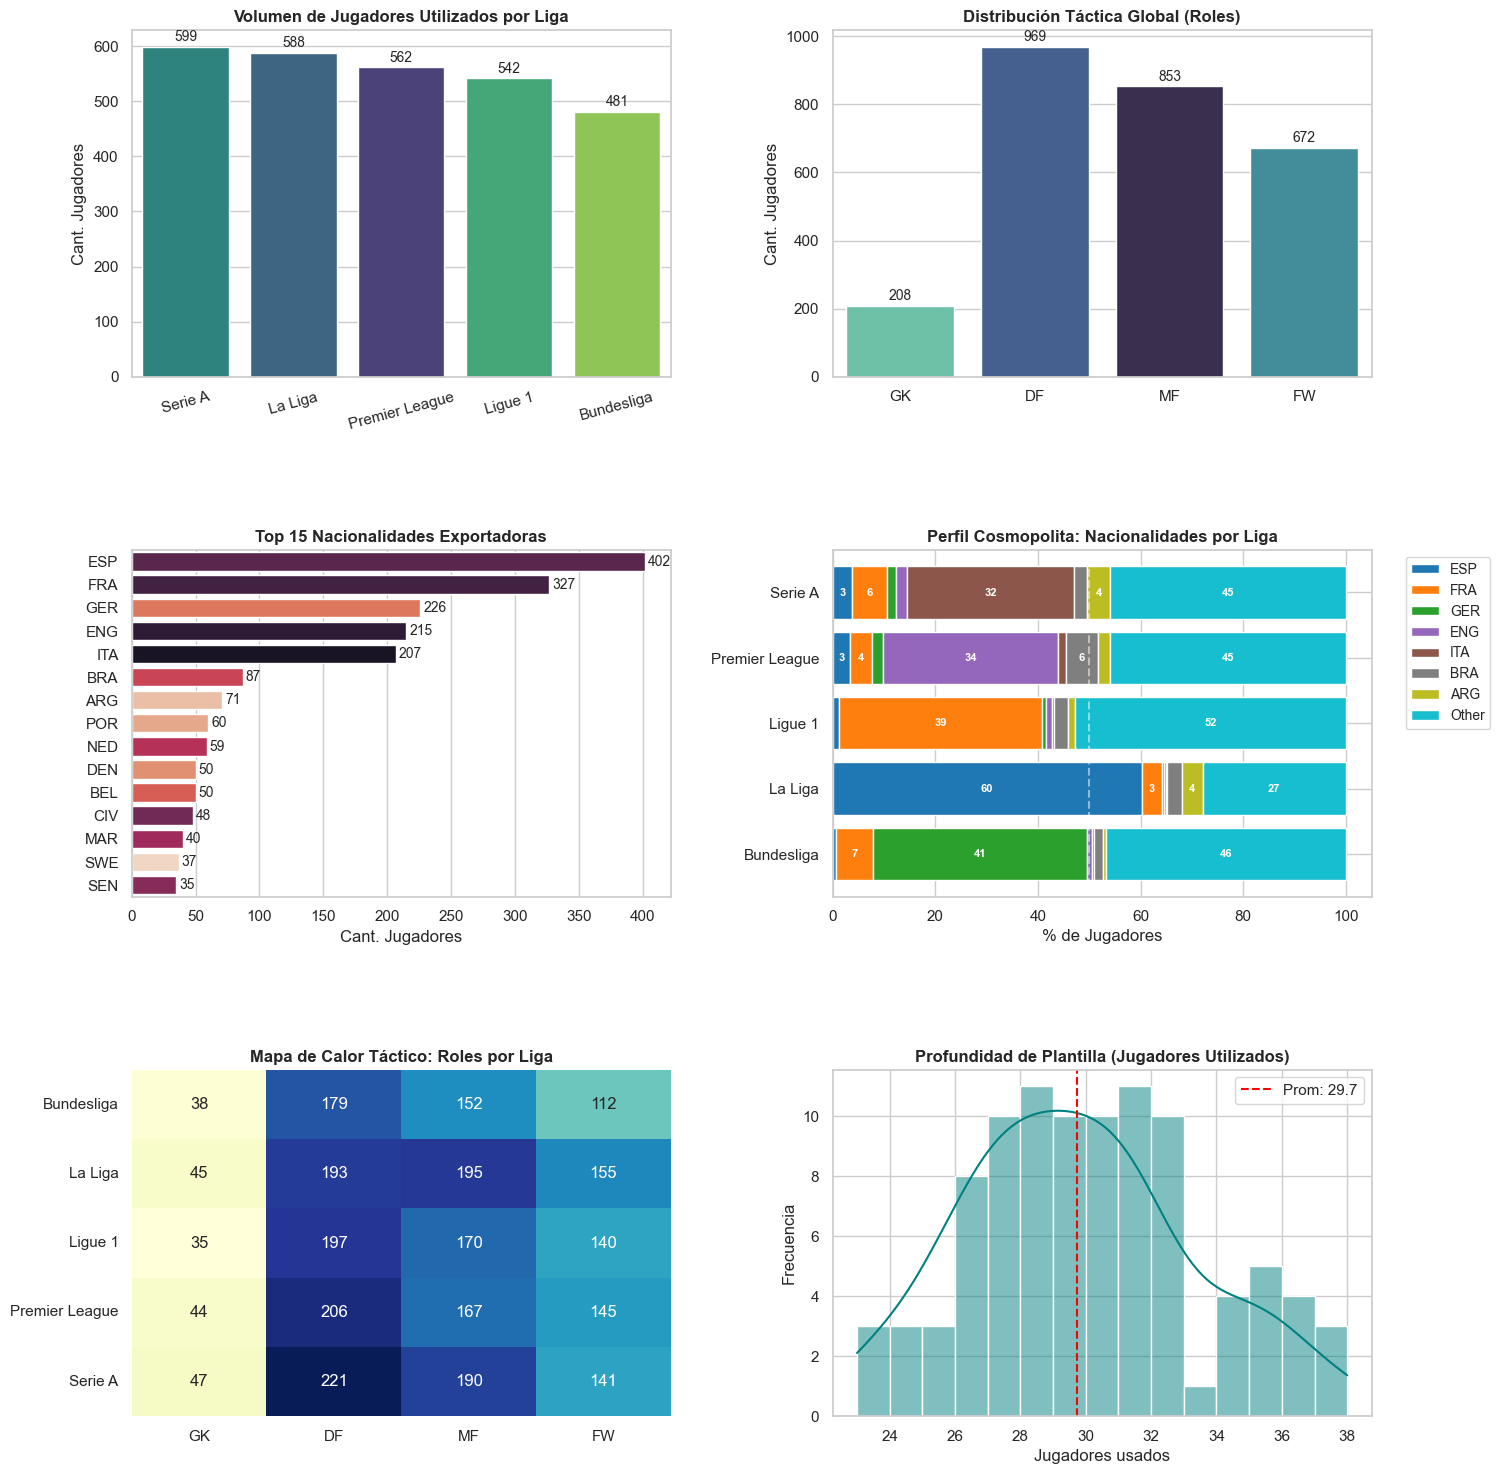


🔎 INSIGHTS DEL ECOSISTEMA:
- Plantilla más rotativa: Valladolid (38 jugadores)
- Plantilla más estable: Werder Bremen (23 jugadores)
- Liga con más Defensas: Serie A
- Liga con más Delanteros: La Liga


In [ ]:
# ======================================
#  ESTADÍSTICAS DESCRIPTIVAS POR LIGA
# ======================================



# -------------------------------------
# 1. PREPARACIÓN DE DATOS (POBLACIONES)
# -------------------------------------
# 1.1. LÓGICA DE LIGAS (Flujo):
# -----------------------------
# Contamos a cada jugador en CADA liga que pisó. Ya se hizo al principio por eso no se repite.
#df_partials = df[df['record_type'] != 'Total'].copy()
#df_anliga = df_partials.drop_duplicates(subset=['player_name', 'league_id']).copy()

# 1.2. LÓGICA GLOBAL (Perfil Único):
# ----------------------------------

# Para posición y nacionalidad, el jugador es una sola persona.
#df_sorted = df.sort_values(by=['player_name', 'team_order'], ascending=[True, True])
#df_global = df_sorted.drop_duplicates(subset='player_name', keep='first').copy()

print(f"👥 Población Única: {len(df_global)}")
print(f"👥 Participaciones en Ligas: {len(df_anliga)}")

# -----------------------
# 2. CONFIGURACIÓN VISUAL
# -----------------------
sns.set_theme(style="whitegrid")
# Aumentamos el tamaño vertical porque ahora hay 3 filas
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# -----------------------------------
# 3. GRÁFICO 1: DISTRIBUCIÓN POR LIGA
# -----------------------------------
sns.countplot(
    data=df_anliga, 
    x='league_id',
    hue='league_id', 
    palette='viridis', 
    ax=axes[0,0],
    legend=False, 
    order=df_anliga['league_id'].value_counts().index
)
axes[0,0].set_title('Volumen de Jugadores Utilizados por Liga', fontsize=12, fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=15)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Cant. Jugadores')
# Etiquetas para cada barra
for container in axes[0,0].containers:
    axes[0,0].bar_label(container, fmt='%d', fontsize=10, padding=2)

# ------------------------------------------
# 4. GRÁFICO 2: POSICIONES TÁCTICAS (GLOBAL)
# ------------------------------------------
sns.countplot(
    data=df_global, 
    x='main_position_group',
    hue='main_position_group', 
    palette='mako', 
    ax=axes[0,1],
    legend=False, 
    order=['GK', 'DF', 'MF', 'FW']
)
axes[0,1].set_title('Distribución Táctica Global (Roles)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Cant. Jugadores')
for container in axes[0,1].containers:
    axes[0,1].bar_label(container, fmt='%d', fontsize=10, padding=2)

# ----------------------------------------------
# 5. GRÁFICO 3: MAPA DE TALENTO (NACIONALIDADES)
# ----------------------------------------------
top_nations = df_global['nation'].value_counts().head(15).index
sns.countplot(
    data=df_global[df_global['nation'].isin(top_nations)], 
    y='nation',
    hue='nation', 
    palette='rocket', 
    ax=axes[1,0],
    legend=False, 
    order=top_nations
)
axes[1,0].set_title('Top 15 Nacionalidades Exportadoras', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Cant. Jugadores')
axes[1,0].set_ylabel('')
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, fmt='%d', fontsize=10, padding=2)

# --------------------------------------------------------------
# 6. GRÁFICO 4: COMPOSICIÓN DE NACIONALIDADES POR LIGA (STACKED)
# --------------------------------------------------------------
# Fix del Warning usando .copy()
df_leagues_plot = df_anliga.copy()
top_nations_global = df_global['nation'].value_counts().head(7).index.tolist()

df_leagues_plot['nation_grouped'] = df_leagues_plot['nation'].apply(
    lambda x: x if x in top_nations_global else 'Other'
)

comp_table = pd.crosstab(
    df_leagues_plot['league_id'], 
    df_leagues_plot['nation_grouped'], 
    normalize='index'
) * 100

cols_order = [c for c in top_nations_global if c in comp_table.columns] + ['Other']
comp_table = comp_table[cols_order]

comp_table.plot(
    kind='barh', 
    stacked=True, 
    ax=axes[1,1], 
    colormap='tab10', 
    edgecolor='white',
    width=0.8
)
# Etiquetas para cada dato dentro de la barra
for c in axes[1,1].containers:
    # Solo ponemos número si es mayor al 3% para no ensuciar
    labels = [f'{int(v.get_width())}' if v.get_width() > 3 else '' for v in c]
    
    axes[1,1].bar_label(
        c, 
        labels=labels,
        label_type='center', # Pone el número ADENTRO de la barra
        fontsize=8, 
        color='white', 
        fontweight='bold'
    )

axes[1,1].set_title('Perfil Cosmopolita: Nacionalidades por Liga', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('% de Jugadores')
axes[1,1].set_ylabel('')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
axes[1,1].axvline(50, color='white', linestyle='--', alpha=0.5)



# ---------------------------------
# 7. GRÁFICO 5: POSICIONES POR LIGA
# ---------------------------------
# Usamos Heatmap para ver la densidad táctica
pos_league_table = pd.crosstab(
    df_anliga['league_id'], 
    df_anliga['main_position_group']
)
# Reordenamos columnas lógicamente
pos_league_table = pos_league_table[['GK', 'DF', 'MF', 'FW']]

# Normalizamos por fila para ver % (opcional, aquí usamos conteo absoluto con color)
sns.heatmap(
    pos_league_table, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu', 
    ax=axes[2,0], 
    cbar=False
)
axes[2,0].set_title('Mapa de Calor Táctico: Roles por Liga', fontsize=12, fontweight='bold')
axes[2,0].set_xlabel('')
axes[2,0].set_ylabel('')

# -----------------------------------------------
# 8. GRÁFICO 6: GESTIÓN DE PLANTILLA (SQUAD SIZE)
# -----------------------------------------------
# Lo movemos a la posición [2,1]
squad_sizes = df[df['record_type'] != 'Total']['squad'].value_counts()

sns.histplot(squad_sizes, bins=15, kde=True, color='teal', ax=axes[2,1])
axes[2,1].set_title('Profundidad de Plantilla (Jugadores Utilizados)', fontsize=12, fontweight='bold')
axes[2,1].set_xlabel('Jugadores usados')
axes[2,1].set_ylabel('Frecuencia')
axes[2,1].axvline(squad_sizes.mean(), color='red', linestyle='--', label=f'Prom: {squad_sizes.mean():.1f}')
axes[2,1].legend()

plt.show()

# ------------------------
# 9. INSIGHTS DEL ANÁLISIS
# ------------------------
print("\n🔎 INSIGHTS DEL ECOSISTEMA:")
print(f"- Plantilla más rotativa: {squad_sizes.idxmax()} ({squad_sizes.max()} jugadores)")
print(f"- Plantilla más estable: {squad_sizes.idxmin()} ({squad_sizes.min()} jugadores)")
print(f"- Liga con más Defensas: {pos_league_table['DF'].idxmax()}")
print(f"- Liga con más Delanteros: {pos_league_table['FW'].idxmax()}")


📊 CONTABILIDAD DE MERCADO (BIG 5) - VOLUMEN TOTAL:


,Base Inicial,Altas (In),Bajas (Out),Neto,Máx. Participantes en Temp.,Tasa de Movimiento
Serie A,585,14,19,-5,599,5.5%
La Liga,576,12,10,2,588,3.7%
Premier League,562,0,35,-35,562,6.2%
Ligue 1,520,22,6,16,542,5.2%
Bundesliga,459,22,0,22,481,4.6%


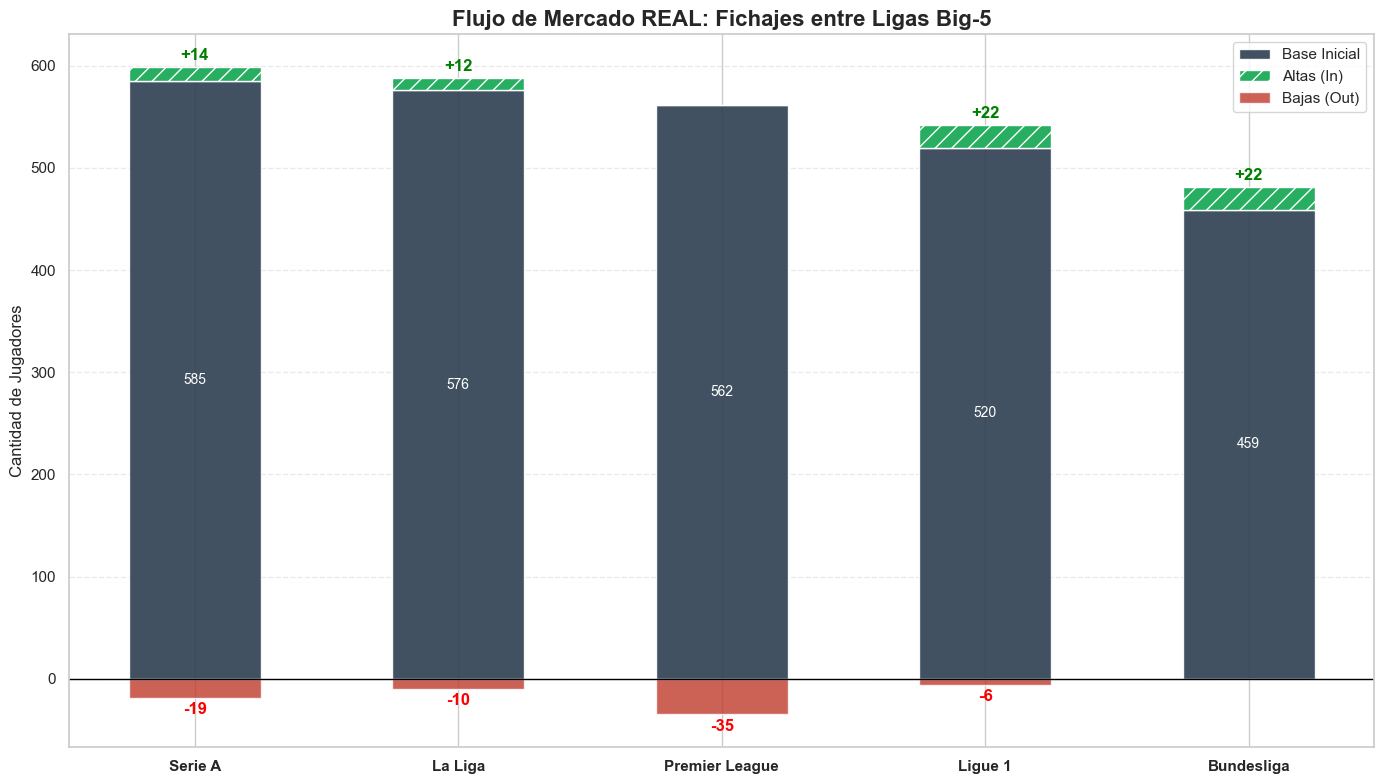


🧠 INSIGHTS DEL MERCADO:
1. Mayor inestabilidad (Rotación): Premier League
2. Mayor estabilidad (Fidelidad): La Liga
Total Movimientos Registrados (Cambio de equipo): 152
Total Movimientos INTER-LIGAS (Cambio de país): 70
(Si este último número es bajo, aprox 50-100, el cálculo es correcto).


In [21]:
# ========================================
# ANÁLISIS DE MOVIMIENTOS Y FLUJO DE LIGAS
# ========================================

# ---------------------------------------------
# 1. PREPARACIÓN DE DATOS PARA ANÁLISIS DE FLUJO
# ---------------------------------------------

# Filtramos parciales y ordenamos
df_flow = df[df['record_type'] != 'Total'].sort_values(['player_name', 'team_order']).copy()

# Quitamos espacios invisibles que rompen la comparación
df_flow['league_id'] = df_flow['league_id'].astype(str).str.strip()

# -----------------------------------------
# 2. DETECCIÓN DE LIGA ANTERIOR DEL JUGADOR
# -----------------------------------------

# Creamos columna de la primera liga que tuvo el jugador usando shift()
# Groupby asegura que el shift() sea DENTRO del historial del mismo jugador
df_flow['prev_league'] = df_flow.groupby('player_name')['league_id'].shift(1)

# ----------------------------------------
# 3. CÁLCULO DE MÉTRICAS DE FLUJO POR LIGA
# ----------------------------------------

# Jugadores que arrancaron la temporada (Orden 1)
base_counts = df_flow[df_flow['team_order'] == 1]['league_id'].value_counts()

# -------------------------------------
# 4. IDENTIFICACIÓN DE TRASPASOS REALES
# -------------------------------------

# Filtramos solo los movimientos que son traspasos reales entre equipos
# Condición 1: Es un registro posterior (Order > 1)
# Condición 2: Sabemos de dónde viene (prev_league no es nulo)
transfers = df_flow[
    (df_flow['team_order'] > 1) & 
    (df_flow['prev_league'].notna())
].copy()

# -------------------------------
# 5. CLASIFICACIÓN DE MOVIMIENTOS
# -------------------------------

# 5.1. Cálculo de Altas y Bajas por Liga
# --------------------------------------

# Importación: La liga actual ES DISTINTA a la anterior
# Exportación: La liga anterior ERA DISTINTA a la actual
# (Esto filtra los movimientos internos como Juventus -> Milan)

imports_series = transfers[transfers['league_id'] != transfers['prev_league']]['league_id'].value_counts()
exports_series = transfers[transfers['league_id'] != transfers['prev_league']]['prev_league'].value_counts()

# 5.2. Consolidación del DataFrame Maestro
# ----------------------------------------

market_df = pd.DataFrame({
    'Base Inicial': base_counts,
    'Altas (In)': imports_series,
    'Bajas (Out)': exports_series
}).fillna(0)

# 5.3. Nuevas Métricas de Mercado
# -------------------------------

# Traspasos Netos
market_df['Neto'] = market_df['Altas (In)'] - market_df['Bajas (Out)']

# Máximo de Participantes en la Temporada (Base + Altas)
market_df['Máx. Participantes en Temp.'] = market_df['Base Inicial'] + market_df['Altas (In)']

# Tasa de Rotación (Churn Rate)
market_df['Tasa de Movimiento'] = (market_df['Altas (In)'] + market_df['Bajas (Out)']) / market_df['Máx. Participantes en Temp.']

# Ordenamos por Volumen Total
market_df = market_df.sort_values('Máx. Participantes en Temp.', ascending=False)

print("\n📊 CONTABILIDAD DE MERCADO (BIG 5) - VOLUMEN TOTAL:")
display(market_df.style.format("{:.0f}", subset=['Base Inicial', 'Altas (In)', 'Bajas (Out)', 'Máx. Participantes en Temp.', 'Neto'])\
                   .format("{:.1%}", subset=['Tasa de Movimiento'])\
                   .background_gradient(cmap='Blues', subset=['Máx. Participantes en Temp.'])\
                   .background_gradient(cmap='Greens', subset=['Altas (In)'])\
                   .background_gradient(cmap='Reds', subset=['Bajas (Out)']))

# 5.4 Visualización Gráfica del Flujo de Mercado
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(14, 8))

indices = range(len(market_df))
width = 0.5

# Colores
color_base = '#2c3e50'
color_in = '#27ae60'
color_out = '#c0392b'

# Barras
bars_base = ax.bar(indices, market_df['Base Inicial'], width, label='Base Inicial', color=color_base, alpha=0.9)
bars_in = ax.bar(indices, market_df['Altas (In)'], width, bottom=market_df['Base Inicial'], 
                 label='Altas (In)', color=color_in, hatch='//')
bars_out = ax.bar(indices, -market_df['Bajas (Out)'], width, label='Bajas (Out)', color=color_out, alpha=0.8)

# Decoración
ax.axhline(0, color='black', linewidth=1)
ax.set_title('Flujo de Mercado REAL: Fichajes entre Ligas Big-5', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de Jugadores')
ax.set_xticks(indices)
ax.set_xticklabels(market_df.index, fontsize=11, fontweight='bold')

# Etiquetas (Solo mostramos si el valor > 0 para limpiar el gráfico)
ax.bar_label(bars_base, label_type='center', color='white', fontsize=10, fmt='%d')
ax.bar_label(bars_in, padding=3, fmt='+%d', color='green', fontweight='bold', 
             labels=[f'+{int(v)}' if v > 0 else '' for v in market_df['Altas (In)']])
ax.bar_label(bars_out, padding=3, fmt='-%d', color='red', fontweight='bold',
             labels=[f'-{int(v)}' if v > 0 else '' for v in market_df['Bajas (Out)']])

plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 5.5 Insights Automáticos
# ----------------------

print("\n🧠 INSIGHTS DEL MERCADO:")
print(f"1. Mayor inestabilidad (Rotación): {market_df['Tasa de Movimiento'].idxmax()}")
print(f"2. Mayor estabilidad (Fidelidad): {market_df['Tasa de Movimiento'].idxmin()}")

# ------------------------------------------------
# 6. DEBUG (Para comparar con datos ya calculados)
# ------------------------------------------------

print(f"Total Movimientos Registrados (Cambio de equipo): {len(transfers)}")
print(f"Total Movimientos INTER-LIGAS (Cambio de país): {imports_series.sum()}")
print("(Si este último número es bajo, aprox 50-100, el cálculo es correcto).")

In [ ]:

# --- LÓGICA DE CONSOLIDACIÓN INTRA-LIGA (CORREGIDA) ---
# Objetivo: Sumar volúmenes y RECALCULAR ratios.

# A. Filtrar Parciales
df_partials = df[df['record_type'] != 'Total'].copy()

# B. Definir qué sumar (Solo Volúmenes)
# Excluimos explícitamente porcentajes y per 90s para no sumarlos por error
cols_to_sum = [
    'matches_played', 'starts', 'minutes_played',
    'goals', 'assists', 'xg', 'xa', 'npxg',
    'shots_total', 'shots_on_target',
    'passes_completed', 'passes_attempted',
    'tackles_total', 'interceptions', 'blocks', 'ball_recoveries',
    'progressive_passes', 'progressive_carries',
    'saves', 'goals_against', 'shots_on_target_against',
    'yellow_cards', 'red_cards'
]
# Filtramos solo las que existen en tu DF
cols_to_sum = [c for c in cols_to_sum if c in df_partials.columns]

# C. Definir qué mantener (Metadatos)
# Nos quedamos con el primer valor encontrado (Posición, Nación)
meta_cols = ['player_name', 'league_id', 'nation', 'main_position_group', 'squad']
agg_dict = {col: 'sum' for col in cols_to_sum}
agg_dict.update({col: 'first' for col in meta_cols if col not in ['player_name', 'league_id']})
agg_dict['age'] = 'max' # La edad siempre es la máxima

# D. EJECUTAR FUSIÓN (Suma de Volúmenes)
df_anliga = df_partials.groupby(['player_name', 'league_id']).agg(agg_dict).reset_index()

# E. RECALCULAR RATIOS (Ingeniería de Features en el Agregado)
# Aquí aplicamos tu lógica de "Promedio Ponderado" reconstruyendo la métrica

# 1. Porcentaje de Puntería
if 'shots_total' in df_anliga.columns and 'shots_on_target' in df_anliga.columns:
    df_anliga['shots_on_target_pct'] = (df_anliga['shots_on_target'] / df_anliga['shots_total']).fillna(0) * 100

# 2. Porcentaje de Pases
if 'passes_completed' in df_anliga.columns and 'passes_attempted' in df_anliga.columns:
    df_anliga['pass_completion_pct'] = (df_anliga['passes_completed'] / df_anliga['passes_attempted']).fillna(0) * 100

# 3. Porcentaje de Atajadas (GK)
if 'saves' in df_anliga.columns and 'shots_on_target_against' in df_anliga.columns:
    df_anliga['save_pct'] = (df_anliga['saves'] / df_anliga['shots_on_target_against']).fillna(0) * 100

# 4. Métricas Per 90 (Recalculadas con el nuevo minutaje total)
# Es vital recalcular esto porque el promedio de los promedios es erróneo.
df_anliga['nineties'] = df_anliga['minutes_played'] / 90
metrics_per_90 = ['goals', 'assists', 'xg', 'xa', 'tackles_total', 'progressive_passes']

for m in metrics_per_90:
    if m in df_anliga.columns:
        df_anliga[f'{m}_per_90'] = (df_anliga[m] / df_anliga['nineties']).fillna(0)

print(f"✅ Datos consolidados y Ratios recalculados.")
print(f"👥 Registros únicos por Liga: {len(df_anliga)}")

# ------------------------------------------------------
# TABLA DESCRIPTIVA FINAL (MATEMÁTICAMENTE CORRECTA)
# ------------------------------------------------------
print("\n📊 RADIOGRAFÍA ESTADÍSTICA POR LIGA (Datos Ponderados)")
print("="*60)

# Seleccionamos métricas para mostrar (incluyendo los ratios recalculados)
metrics_show = [
    'age', 'matches_played', 'minutes_played', 
    'goals', 'xg', 'goals_per_90', # Volúmenes y Ratios Ofensivos
    'pass_completion_pct', 'progressive_passes', # Juego
    'tackles_total', # Defensa
    'save_pct' # Portería
]
# Filtrar existentes
metrics_show = [c for c in metrics_show if c in df_anliga.columns]

# Agrupar y Calcular Media de la Liga
# Ahora sí podemos hacer mean() porque cada fila es un jugador con sus % ponderados correctos
league_stats_final = df_anliga.groupby('league_id')[metrics_show].mean()

# Añadir conteo
league_stats_final.insert(0, 'Jugadores', df_anliga['league_id'].value_counts())

display(league_stats_final.style.background_gradient(cmap='Greens', axis=0).format("{:.2f}"))

✅ Datos consolidados y Ratios recalculados.
👥 Registros únicos por Liga: 2772

📊 RADIOGRAFÍA ESTADÍSTICA POR LIGA (Datos Ponderados)


,Jugadores,age,matches_played,minutes_played,goals,xg,goals_per_90,pass_completion_pct,progressive_passes,tackles_total,save_pct
league_id,,,,,,,,,,,
Bundesliga,481.00,25.22,19.81,1256.43,1.94,1.88,0.13,75.75,48.05,19.74,4.95
La Liga,588.00,25.35,20.24,1276.04,1.65,1.69,0.10,75.99,47.09,21.05,4.87
Ligue 1,542.00,24.11,17.37,1114.32,1.63,1.72,0.12,78.32,44.34,20.28,4.01
Premier League,562.00,25.04,20.58,1336.17,1.93,1.96,0.11,78.02,49.98,23.79,5.12
Serie A,599.00,25.26,19.79,1249.01,1.56,1.56,0.10,77.66,43.64,19.27,5.14



>>> RADIOGRAFÍA DETALLADA POR LIGAS (2 Variables por Aspecto). PROMEDIOS <<<


,age,matches_played,minutes_played,goals,assists,xg,xa,tackles_total,progressive_passes,saves
league_id,,,,,,,,,,
Bundesliga,25.20,19.37,1228.34,1.90,1.36,1.84,1.50,19.30,46.97,3.63
La Liga,25.35,19.80,1248.43,1.61,1.12,1.66,1.13,20.59,46.07,3.39
Ligue 1,24.11,17.02,1092.16,1.60,1.11,1.69,1.16,19.88,43.46,3.40
Premier League,25.03,20.15,1308.24,1.89,1.40,1.92,1.25,23.30,48.93,3.96
Serie A,25.24,18.70,1180.06,1.47,1.05,1.47,0.92,18.21,41.24,3.21



>>> BOX PLOTS POR LIGA <<<


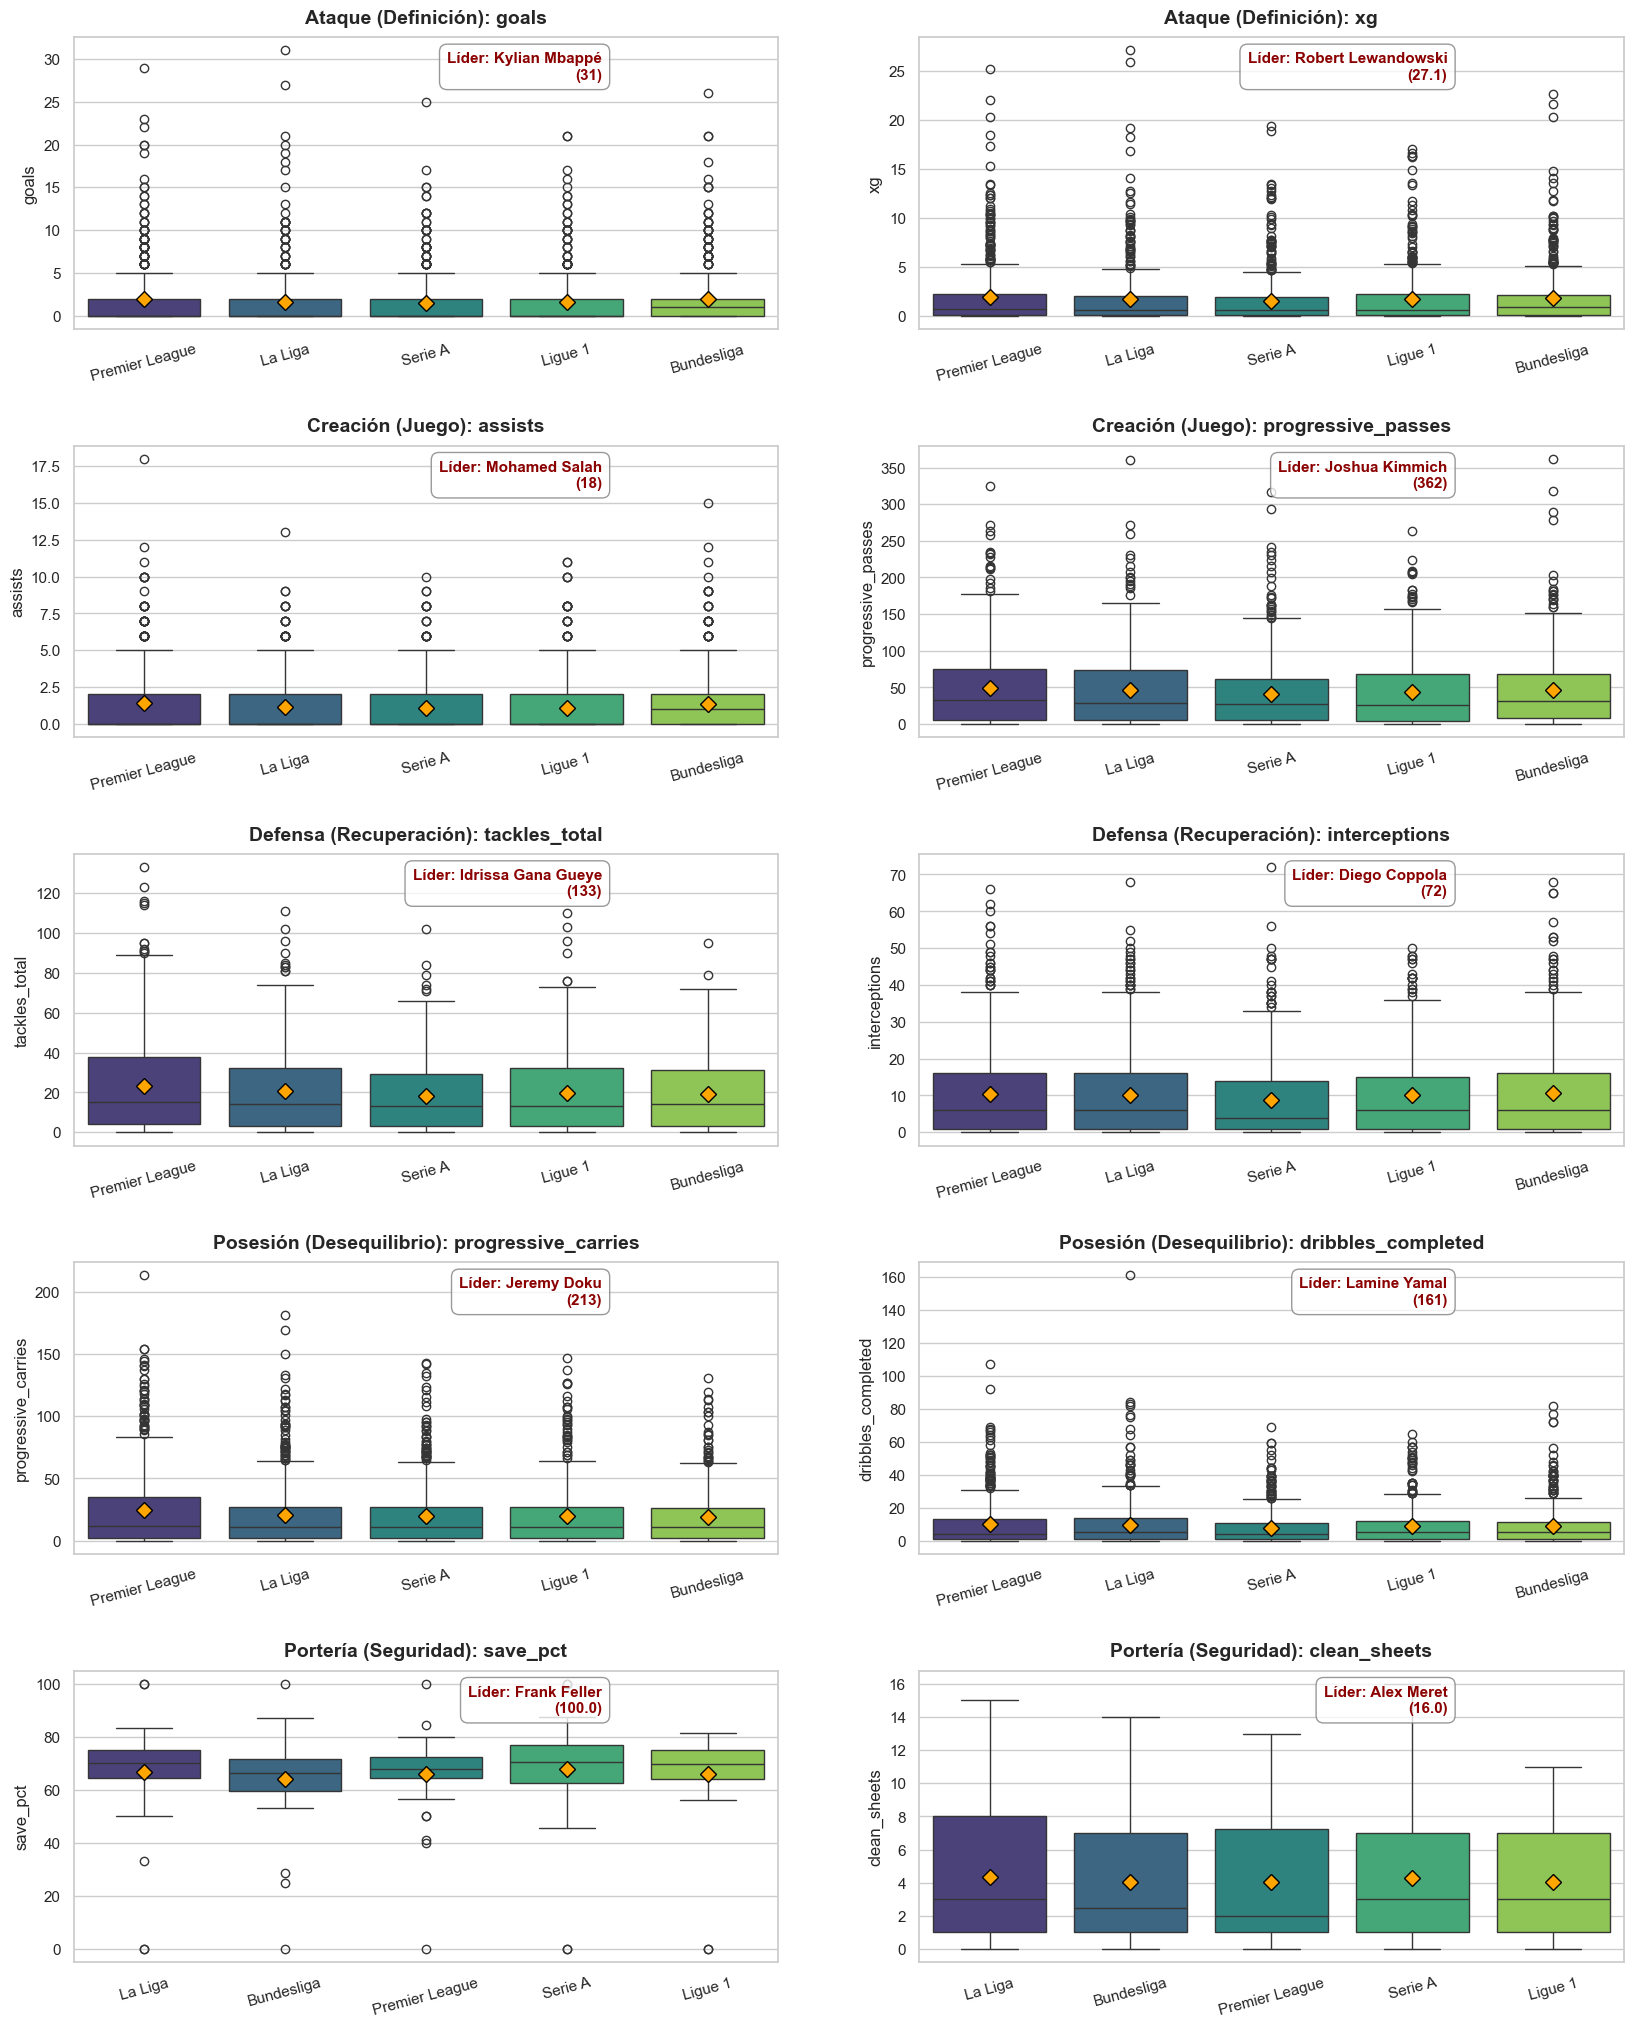

In [10]:
# BOX PLOT DE VARIABLES SELECCIONADAS

# 1. FILTRO ESTRATÉGICO
df_leagues = df[df['league_id'] != 'Multiple'].copy()

# 2. SELECCIÓN DE VARIABLES
metrics_aspects = {
    'Ataque (Definición)': ['goals', 'xg'],
    'Creación (Juego)': ['assists', 'progressive_passes'],
    'Defensa (Recuperación)': ['tackles_total', 'interceptions'],
    'Posesión (Desequilibrio)': ['progressive_carries', 'dribbles_completed'],
    'Portería (Seguridad)': ['save_pct', 'clean_sheets']
}

# 3. TABLA COMPARATIVA DE PROMEDIOS
print("\n>>> RADIOGRAFÍA DETALLADA POR LIGAS (2 Variables por Aspecto). PROMEDIOS <<<")
league_stats = df_leagues.groupby('league_id')[metrics].mean()
display(league_stats.style.background_gradient(cmap='Greens', axis=0).format("{:.2f}"))

# 4. GRÁFICO BOX PLOT
print("\n>>> BOX PLOTS POR LIGA <<<")

# 4.1 CONFIGURACIÓN VISUAL ROBUSTA
plt.rcParams['figure.figsize'] = (20, 22)
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(5, 2, figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

row = 0
for aspect, metrics in metrics_aspects.items():
    col = 0
    for metric in metrics:
        if metric in df_leagues.columns:
            # Filtro de datos
            if aspect == 'Portería (Seguridad)':
                 data_to_plot = df_leagues[df_leagues['main_position_group'] == 'GK']
            else:
                 data_to_plot = df_leagues

            # DIBUJAR BOXPLOT CON MEDIA VISIBLE
            sns.boxplot(
                data=data_to_plot, 
                x='league_id', 
                y=metric,
                hue='league_id',
                legend=False, 
                ax=axes[row, col], 
                palette='viridis',
                showfliers=True,
                
                # --- AQUÍ ESTÁ EL CAMBIO PARA VER LA MEDIA ---
                showmeans=True, 
                meanprops={
                    "marker": "D",              # Forma: Rombo (Diamond)
                    "markerfacecolor": "orange", # Color: Blanco brillante
                    "markeredgecolor": "black", # Borde: Negro para contraste
                    "markersize": 8             # Tamaño: Grande
                }
            )
            
            # Títulos y Ejes
            axes[row, col].set_title(f'{aspect}: {metric}', fontsize=14, fontweight='bold', pad=10)
            axes[row, col].tick_params(axis='x', rotation=15, labelsize=11)
            axes[row, col].set_xlabel('')
            
            # --- ETIQUETAR AL LÍDER ---
            if not data_to_plot.empty:
                max_val = data_to_plot[metric].max()
                best_idx = data_to_plot[metric].idxmax()
                
                if best_idx in data_to_plot.index:
                    best_player = data_to_plot.loc[best_idx, 'player_name']
                    
                    axes[row, col].text(
                        x=0.75, y=0.95, 
                        s=f"Líder: {best_player}\n({max_val})", 
                        transform=axes[row, col].transAxes, 
                        ha='right', va='top', 
                        fontsize=11, color='darkred', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5')
                    )

        col += 1
    row += 1

plt.show()

In [ ]:
# Selección de métricas clave (Cuantitativas)

# 1. Filtro: Población Objetivo (Sin 'Multiple')

# Queremos comparar las ligas "puras", así que eliminamos los registros combinados.
# Usamos las filas parciales para que cada jugador cuente en la liga donde jugó.
df_leagues = df[df['league_id'] != 'Multiple'].copy()

# 2. Selección de métricas clave (Cuantitativas)
metrics = [
    'age', 'matches_played', 'minutes_played', 
    'goals', 'assists', 'xg', 'xa', 
    'tackles_total', 'progressive_passes', 'saves'
]
# 3. Filtrar solo las existentes
metrics = [c for c in metrics if c in df.columns]

# 4. Generación de Reporte Iterativo
print("📊 RADIOGRAFÍA ESTADÍSTICA DETALLADA POR LIGA")
print("="*60)

cols_order = ['count', 'mean', 'median', 'std', 'min', 'max', '25%', '75%', 'skewness', 'kurtosis']
ligas = sorted(df_leagues['league_id'].unique())

for liga in ligas:
    print(f"\n>>> 🏆 ANÁLISIS: {liga.upper()} <<<")
    
    # Filtrar datos de esa liga
    df_subset = df_leagues[df_leagues['league_id'] == liga][metrics]
    
    # Calcular describe básico
    desc = df_subset.describe().T
    
    # Añadir métricas avanzadas de forma
    desc['median'] = df_subset.median(numeric_only=True)
    desc['skewness'] = df_subset.skew(numeric_only=True)
    desc['kurtosis'] = df_subset.kurt(numeric_only=True)
    
    # Mostrar tabla formateada
    display(desc[cols_order].style.format("{:.2f}").background_gradient(cmap='Reds', subset=['skewness', 'kurtosis']))
    print("-" * 100)

# 5. Comparativa de los promedios de las ligas ---
print("\n🏆 PROMEDIOS POR LIGA (Comparativa de Estilos)")
print("="*60)
league_means = df_leagues.groupby('league_id')[metrics].mean()
display(league_means.style.background_gradient(cmap='Greens', axis=0)) # Colorear para ver quién gana

📊 RADIOGRAFÍA ESTADÍSTICA DETALLADA POR LIGA

>>> 🏆 ANÁLISIS: BUNDESLIGA <<<


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis
age,492.00,25.20,25.00,4.22,16.00,38.00,22.00,28.00,0.25,-0.31
matches_played,492.00,19.37,21.00,10.39,1.00,34.00,11.00,29.00,-0.32,-1.22
minutes_played,492.00,1228.34,1157.00,909.37,1.00,3060.00,364.00,1950.00,0.30,-1.17
goals,492.00,1.90,1.00,3.34,0.00,26.00,0.00,2.00,3.10,12.45
assists,492.00,1.36,1.00,2.14,0.00,15.00,0.00,2.00,2.41,7.13
xg,492.00,1.84,0.90,2.88,0.00,22.70,0.10,2.10,3.36,15.53
xa,492.00,1.50,0.80,1.86,0.00,12.50,0.20,2.00,2.21,6.16
tackles_total,492.00,19.30,14.00,18.68,0.00,95.00,3.00,31.00,0.97,0.26
progressive_passes,492.00,46.97,31.00,51.28,0.00,362.00,7.75,68.00,1.87,5.49
saves,492.00,3.63,0.00,15.97,0.00,105.00,0.00,0.00,4.81,22.66


----------------------------------------------------------------------------------------------------

>>> 🏆 ANÁLISIS: LA LIGA <<<


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis
age,601.00,25.35,25.00,4.63,16.00,38.00,21.00,29.00,0.30,-0.62
matches_played,601.00,19.80,22.00,11.88,1.00,38.00,9.00,31.00,-0.21,-1.32
minutes_played,601.00,1248.43,1106.00,965.05,2.00,3420.00,360.00,2039.00,0.37,-1.10
goals,601.00,1.61,0.00,3.24,0.00,31.00,0.00,2.00,4.20,24.45
assists,601.00,1.12,0.00,1.78,0.00,13.00,0.00,2.00,2.22,6.13
xg,601.00,1.66,0.60,2.89,0.00,27.10,0.10,2.00,4.10,24.05
xa,601.00,1.13,0.50,1.60,0.00,12.60,0.10,1.50,2.72,10.69
tackles_total,601.00,20.59,14.00,20.70,0.00,111.00,3.00,32.00,1.21,1.20
progressive_passes,601.00,46.07,28.00,50.84,0.00,360.00,5.00,73.00,1.61,3.66
saves,601.00,3.39,0.00,15.97,0.00,140.00,0.00,0.00,5.46,31.26


----------------------------------------------------------------------------------------------------

>>> 🏆 ANÁLISIS: LIGUE 1 <<<


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis
age,553.00,24.11,24.00,4.68,15.00,40.00,20.00,27.00,0.41,-0.46
matches_played,553.00,17.02,16.00,10.72,1.00,34.00,8.00,27.00,-0.05,-1.37
minutes_played,553.00,1092.16,951.00,894.34,1.00,3060.00,265.00,1805.00,0.46,-1.01
goals,553.00,1.60,0.00,2.93,0.00,21.00,0.00,2.00,3.09,11.96
assists,553.00,1.11,0.00,1.87,0.00,11.00,0.00,2.00,2.46,7.01
xg,553.00,1.69,0.60,2.71,0.00,17.00,0.10,2.20,2.89,10.27
xa,553.00,1.16,0.50,1.62,0.00,11.70,0.10,1.60,2.22,6.26
tackles_total,553.00,19.88,13.00,20.48,0.00,110.00,3.00,32.00,1.17,1.03
progressive_passes,553.00,43.46,26.00,48.18,0.00,263.00,4.00,68.00,1.33,1.44
saves,553.00,3.40,0.00,17.05,0.00,135.00,0.00,0.00,5.84,35.55


----------------------------------------------------------------------------------------------------

>>> 🏆 ANÁLISIS: PREMIER LEAGUE <<<


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis
age,574.00,25.03,25.00,4.50,15.00,39.00,22.00,28.00,0.27,-0.27
matches_played,574.00,20.15,21.00,12.23,1.00,38.00,9.00,32.00,-0.15,-1.39
minutes_played,574.00,1308.24,1103.50,1053.65,1.00,3420.00,331.25,2204.00,0.38,-1.18
goals,574.00,1.89,0.00,3.54,0.00,29.00,0.00,2.00,3.25,13.91
assists,574.00,1.40,0.00,2.25,0.00,18.00,0.00,2.00,2.44,8.12
xg,574.00,1.92,0.70,3.18,0.00,25.20,0.10,2.20,3.13,12.93
xa,574.00,1.25,0.60,1.67,0.00,9.30,0.10,1.70,2.01,4.31
tackles_total,574.00,23.30,15.00,24.39,0.00,133.00,4.00,38.00,1.38,1.86
progressive_passes,574.00,48.93,32.50,53.90,0.00,325.00,6.00,74.75,1.52,2.65
saves,574.00,3.96,0.00,17.89,0.00,150.00,0.00,0.00,5.15,27.28


----------------------------------------------------------------------------------------------------

>>> 🏆 ANÁLISIS: SERIE A <<<


,count,mean,median,std,min,max,25%,75%,skewness,kurtosis
age,634.00,25.24,25.00,4.36,16.00,41.00,22.00,28.00,0.37,-0.19
matches_played,634.00,18.70,18.00,11.74,1.00,38.00,8.00,30.00,0.01,-1.35
minutes_played,634.00,1180.06,1027.00,974.02,1.00,3420.00,298.25,1916.00,0.56,-0.86
goals,634.00,1.47,0.00,2.69,0.00,25.00,0.00,2.00,3.33,15.73
assists,634.00,1.05,0.00,1.66,0.00,10.00,0.00,2.00,2.14,5.34
xg,634.00,1.47,0.60,2.40,0.00,19.40,0.10,1.90,3.34,14.77
xa,634.00,0.92,0.50,1.22,0.00,7.90,0.10,1.30,2.09,4.91
tackles_total,634.00,18.21,13.00,18.20,0.00,102.00,3.00,29.00,1.07,0.69
progressive_passes,634.00,41.24,27.00,46.43,0.00,316.00,5.00,60.75,1.87,4.96
saves,634.00,3.21,0.00,15.42,0.00,129.00,0.00,0.00,5.65,33.23


----------------------------------------------------------------------------------------------------

🏆 PROMEDIOS POR LIGA (Comparativa de Estilos)


,age,matches_played,minutes_played,goals,assists,xg,xa,tackles_total,progressive_passes,saves
league_id,,,,,,,,,,
Bundesliga,25.203252,19.365854,1228.337398,1.898374,1.363821,1.842073,1.499390,19.296748,46.971545,3.632114
La Liga,25.351082,19.800333,1248.434276,1.612313,1.119800,1.656240,1.131614,20.592346,46.069884,3.391015
Ligue 1,24.112116,17.019892,1092.159132,1.600362,1.106691,1.687703,1.162025,19.878843,43.461121,3.403255
Premier League,25.033101,20.151568,1308.240418,1.885017,1.400697,1.919164,1.247387,23.296167,48.930314,3.958188
Serie A,25.241325,18.700315,1180.061514,1.471609,1.052050,1.474606,0.924921,18.206625,41.235016,3.211356


#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)

In [ ]:
# ==============================================================================
# PARTE 2: ANÁLISIS INTRA-GRUPAL (POR POSICIONES)
# ==============================================================================
print("\n" + "="*50)
print("2. ANÁLISIS INTRA-GRUPAL (SEGREGACIÓN POSICIONAL)")
print("="*50)

# Filtramos "ruido" para este análisis (Jugadores > 450 min)
df_core = df[df['minutes_played'] > 450].copy()
print(f"Analizando subconjunto de {len(df_core)} jugadores con > 450 minutos.")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Grupo Delanteros (FW) - Eficiencia
sns.boxplot(data=df_core, x='main_position_group', y='goals', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribución de GOLES por Posición')

# B. Grupo Creativos (MF) - Progresión
sns.boxplot(data=df_core, x='main_position_group', y='progressive_passes', ax=axes[0,1], palette='mako')
axes[0,1].set_title('Distribución de PASES PROGRESIVOS por Posición')

# C. Grupo Defensivo (DF) - Destrucción
sns.boxplot(data=df_core, x='main_position_group', y='tackles_total', ax=axes[1,0], palette='rocket')
axes[1,0].set_title('Distribución de TACKLES por Posición')

# D. Grupo Porteros (GK) - Trabajo
# Filtramos solo GK para que el gráfico no quede vacío en otras posiciones
df_gk = df_core[df_core['main_position_group'] == 'GK']
if not df_gk.empty:
    sns.violinplot(data=df_gk, y='saves', ax=axes[1,1], color='cyan')
    axes[1,1].set_title('Densidad de ATAJADAS (Solo Arqueros)')
else:
    axes[1,1].text(0.5, 0.5, 'Sin datos de GK suficientes', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# PARTE 3: ANÁLISIS INTER-GRUPOS Y CONSISTENCIA (MICRO)
# ==============================================================================
print("\n" + "="*50)
print("3. ANÁLISIS DE CONSISTENCIA Y RELACIONES (CRUCE DE VARIABLES)")
print("="*50)

# A. Correlaciones Tácticas (Heatmap)
# ¿Se mueven juntas las métricas defensivas?
cols_def = ['tackles_total', 'interceptions', 'blocks', 'ball_recoveries', 'yellow_cards']
corr_mat = df_core[cols_def].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('3.A. Matriz de Coherencia Defensiva', fontsize=14, fontweight='bold')
plt.show()

# B. Scatter de Anomalías: Goles vs xG
# Buscamos "Overperformers" (Talento/Suerte) y "Underperformers" (Mala racha)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_core, x='xg', y='goals', hue='main_position_group', alpha=0.6, palette='deep')
# Línea de identidad
limit = max(df_core['goals'].max(), df_core['xg'].max())
plt.plot([0, limit], [0, limit], 'r--', alpha=0.5, label='Rendimiento Esperado')
plt.title('3.B. Consistencia Ofensiva: Realidad vs Expectativa', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# C. Detección de Anomalías Específicas (El caso del "Portero Loco")
# Pregunta del usuario: ¿Hay porteros con muchas tarjetas amarillas?
print("\n--- 3.C. Detección de Anomalías: Porteros Indisciplinados ---")
gks_cards = df_core[df_core['main_position_group'] == 'GK'][['player_name', 'squad', 'yellow_cards']].sort_values('yellow_cards', ascending=False)
top_bad_boys = gks_cards.head(5)

if not top_bad_boys.empty:
    print("Top 5 Arqueros con más amarillas:")
    print(top_bad_boys)
    
    # Gráfico rápido si hay datos
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top_bad_boys, x='yellow_cards', y='player_name', palette='Reds_r')
    plt.title('Anomalía: Arqueros con más Tarjetas Amarillas')
    plt.show()
else:
    print("No se encontraron arqueros con tarjetas en el corte seleccionado.")

print("\n" + "="*50)
print("✅ EDA FINALIZADO. DIAGNÓSTICO COMPLETO.")
print("="*50)